- FONDKAPREMONT_MODE中的nan與not specified意義不同，因一個是沒值(沒有這項房屋特性)，另一為沒說明

- 其他類別型欄位的na值已自動被抓出，可自成一類

- int欄位皆沒有na

- 預計以AMT_GOODS_PRICE,AMT_CREDIT建模推估AMT_ANNUITY的空值

- 預計以AMT_CREDIT,AMT_ANNUITY建模推估AMT_GOODS_PRICE的空值

- 車齡有0與nan,且nan量太多，預計以0填補，並另增一欄標註。

- CNT_FAM_MEMBERS只有2個na，可以0或眾數補值

- EXT_SOURCE_1的na佔56%，EXT_SOURCE_2的na佔0.2%，EXT_SOURCE_3的na佔20%

- 以及房屋特徵欄位

- 皆預計以0填補，並新增一欄標註

- 雖然社交環境方面的相關變數彼此高度相關，但常常是同時都為空值，所以不適合以模型填補。

- 預計以0填補，並新增一欄標記

- 預計以0填補AMT_REQ_CREDIT_BUREAU_HOUR

- AMT_GOODS_PRICE/AMT_CREDIT是否最大值改成1？這樣跟原值不符會不會有影響？

- DAYS_EMPLOYED有離群值

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
train = pd.read_csv("C:\\final\\home-credit-default-risk\\application_train.csv")

In [3]:
train2 = pd.read_csv("C:\\final\\home-credit-default-risk\\application_train.csv") # 備用復原

In [4]:
pd.set_option('display.max_columns',None)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
pd.set_option('display.max_rows',None)
train.isna().sum()/len(train) # na比例

SK_ID_CURR                      0.000000
TARGET                          0.000000
NAME_CONTRACT_TYPE              0.000000
CODE_GENDER                     0.000000
FLAG_OWN_CAR                    0.000000
FLAG_OWN_REALTY                 0.000000
CNT_CHILDREN                    0.000000
AMT_INCOME_TOTAL                0.000000
AMT_CREDIT                      0.000000
AMT_ANNUITY                     0.000039
AMT_GOODS_PRICE                 0.000904
NAME_TYPE_SUITE                 0.004201
NAME_INCOME_TYPE                0.000000
NAME_EDUCATION_TYPE             0.000000
NAME_FAMILY_STATUS              0.000000
NAME_HOUSING_TYPE               0.000000
REGION_POPULATION_RELATIVE      0.000000
DAYS_BIRTH                      0.000000
DAYS_EMPLOYED                   0.000000
DAYS_REGISTRATION               0.000000
DAYS_ID_PUBLISH                 0.000000
OWN_CAR_AGE                     0.659908
FLAG_MOBIL                      0.000000
FLAG_EMP_PHONE                  0.000000
FLAG_WORK_PHONE 

In [6]:
assert train['SK_ID_CURR'].unique().shape[0] == len(train) # 確認每一列的SK_ID_CURR都不一樣

In [7]:
data_object = train.columns[train.dtypes=='object'] # 挑出object類型欄位
data_object

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [8]:
pd.reset_option('all')


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\ProgramData\Anaconda3\lib\site-packages\pandas\_config\config.py:622: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [9]:
data_object_na = train[data_object].columns[train[data_object].isna().sum()>0] # 類別型變數有空值的欄位
data_object_na

Index(['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

FONDKAPREMONT_MODE中的nan與not specified意義不同，因一個是沒值(沒有這項房屋特性)，另一為沒說明

其他類別型欄位的na值已自動被抓出，可自成一類

In [10]:
data_int = train.columns[train.dtypes=='int64'] # 挑出int類型欄位
data_int

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

In [11]:
train[data_int].isna().sum()/len(train)

SK_ID_CURR                     0.0
TARGET                         0.0
CNT_CHILDREN                   0.0
DAYS_BIRTH                     0.0
DAYS_EMPLOYED                  0.0
DAYS_ID_PUBLISH                0.0
FLAG_MOBIL                     0.0
FLAG_EMP_PHONE                 0.0
FLAG_WORK_PHONE                0.0
FLAG_CONT_MOBILE               0.0
FLAG_PHONE                     0.0
FLAG_EMAIL                     0.0
REGION_RATING_CLIENT           0.0
REGION_RATING_CLIENT_W_CITY    0.0
HOUR_APPR_PROCESS_START        0.0
REG_REGION_NOT_LIVE_REGION     0.0
REG_REGION_NOT_WORK_REGION     0.0
LIVE_REGION_NOT_WORK_REGION    0.0
REG_CITY_NOT_LIVE_CITY         0.0
REG_CITY_NOT_WORK_CITY         0.0
LIVE_CITY_NOT_WORK_CITY        0.0
FLAG_DOCUMENT_2                0.0
FLAG_DOCUMENT_3                0.0
FLAG_DOCUMENT_4                0.0
FLAG_DOCUMENT_5                0.0
FLAG_DOCUMENT_6                0.0
FLAG_DOCUMENT_7                0.0
FLAG_DOCUMENT_8                0.0
FLAG_DOCUMENT_9     

### int欄位皆沒有na

In [12]:
data_float = train.columns[train.dtypes=='float64'] # 挑出float類型欄位
data_float

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI'

In [13]:
data_float_na = train[data_float].columns[train[data_float].isna().sum()>0] # float型變數有空值的欄位
data_float_na

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPART

In [16]:
pd.set_option('display.max_rows',None)
train[data_float].isna().sum()/len(train)

AMT_INCOME_TOTAL                0.000000
AMT_CREDIT                      0.000000
AMT_ANNUITY                     0.000039
AMT_GOODS_PRICE                 0.000904
REGION_POPULATION_RELATIVE      0.000000
DAYS_REGISTRATION               0.000000
OWN_CAR_AGE                     0.659908
CNT_FAM_MEMBERS                 0.000007
EXT_SOURCE_1                    0.563811
EXT_SOURCE_2                    0.002146
EXT_SOURCE_3                    0.198253
APARTMENTS_AVG                  0.507497
BASEMENTAREA_AVG                0.585160
YEARS_BEGINEXPLUATATION_AVG     0.487810
YEARS_BUILD_AVG                 0.664978
COMMONAREA_AVG                  0.698723
ELEVATORS_AVG                   0.532960
ENTRANCES_AVG                   0.503488
FLOORSMAX_AVG                   0.497608
FLOORSMIN_AVG                   0.678486
LANDAREA_AVG                    0.593767
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAREA_AVG                  0.501933
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAREA_AV

In [17]:
pd.reset_option('all')


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



### 檢視ANNUITY的空值狀況

In [13]:
train[train['AMT_ANNUITY'].isna()==True]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
47531,155054,0,Cash loans,M,N,N,0,180000.0,450000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
50035,157917,0,Cash loans,F,N,N,0,94500.0,450000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
51594,159744,0,Cash loans,F,N,N,0,202500.0,539100.0,NaN,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
55025,163757,0,Cash loans,F,N,N,0,162000.0,296280.0,NaN,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
59934,169487,0,Cash loans,M,Y,N,0,202500.0,360000.0,NaN,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,6.0
75873,187985,0,Cash loans,M,Y,N,0,144000.0,219249.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,11.0
89343,203726,0,Cash loans,F,Y,N,0,90000.0,157500.0,NaN,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0
123872,243648,0,Cash loans,F,N,Y,0,202500.0,929088.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0
207186,340147,0,Cash loans,M,N,N,0,171000.0,486000.0,NaN,...,0,0,0,0,0.0,0.0,1.0,1.0,0.0,2.0
227939,364022,0,Cash loans,F,N,Y,0,315000.0,628069.5,NaN,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0


In [14]:
corANNUITY = train.corr()['AMT_ANNUITY'].apply(lambda x:np.abs(x)).sort_values(ascending=False)
corANNUITY.head(20)

AMT_ANNUITY                    1.000000
AMT_GOODS_PRICE                0.775109
AMT_CREDIT                     0.770138
AMT_INCOME_TOTAL               0.191657
REGION_RATING_CLIENT_W_CITY    0.141682
FLAG_DOCUMENT_8                0.130584
FLOORSMAX_AVG                  0.130174
FLOORSMAX_MEDI                 0.129179
REGION_RATING_CLIENT           0.128525
FLOORSMAX_MODE                 0.126302
EXT_SOURCE_2                   0.125804
EXT_SOURCE_1                   0.119398
REGION_POPULATION_RELATIVE     0.118429
DAYS_EMPLOYED                  0.104332
FLAG_EMP_PHONE                 0.103533
FLAG_DOCUMENT_3                0.102843
ELEVATORS_AVG                  0.101439
FLOORSMIN_AVG                  0.099812
ELEVATORS_MEDI                 0.099559
FLOORSMIN_MEDI                 0.098642
Name: AMT_ANNUITY, dtype: float64

#### 預計以AMT_GOODS_PRICE,AMT_CREDIT建模推估AMT_ANNUITY的空值(高度相關的變數)

In [15]:
corGP = train.corr()['AMT_GOODS_PRICE'].apply(lambda x:np.abs(x)).sort_values(ascending=False)
corGP.head(20)

AMT_GOODS_PRICE                1.000000
AMT_CREDIT                     0.986968
AMT_ANNUITY                    0.775109
EXT_SOURCE_1                   0.175502
AMT_INCOME_TOTAL               0.159610
EXT_SOURCE_2                   0.139367
REGION_RATING_CLIENT_W_CITY    0.112208
FLOORSMAX_AVG                  0.108512
FLOORSMAX_MEDI                 0.107936
FLOORSMAX_MODE                 0.105532
REGION_RATING_CLIENT           0.103786
OWN_CAR_AGE                    0.103733
REGION_POPULATION_RELATIVE     0.103520
ELEVATORS_AVG                  0.083736
ELEVATORS_MEDI                 0.082266
FLOORSMIN_AVG                  0.081411
FLOORSMIN_MEDI                 0.080863
FLAG_DOCUMENT_8                0.080482
ELEVATORS_MODE                 0.077978
FLOORSMIN_MODE                 0.077770
Name: AMT_GOODS_PRICE, dtype: float64

#### 預計以AMT_CREDIT,AMT_ANNUITY建模推估AMT_GOODS_PRICE的空值 (高度相關的變數)

### 檢視float類別的欄位空值

In [18]:
train['OWN_CAR_AGE'].unique()

array([nan, 26., 17.,  8., 23.,  7., 14.,  1.,  3., 13., 10.,  2., 21.,
       20., 22., 65.,  5., 11.,  9.,  4., 15., 12., 25.,  6., 64.,  0.,
       27., 19., 28., 18., 16., 30., 36., 24., 39., 29., 40., 41., 31.,
       42., 37., 35., 34., 33., 54., 38., 32., 43., 55., 49., 44., 63.,
       46., 45., 48., 56., 51., 57., 69., 50., 47., 91., 52.])

In [19]:
len(train[train['OWN_CAR_AGE']==0])

2134

In [20]:
len(train[train['OWN_CAR_AGE'].isna()])

202929

車齡有0與nan,且nan量太多，預計以0填補，並另增一欄標註。

In [21]:
train['CNT_FAM_MEMBERS'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  9.,  7.,  8., 10., 13., nan, 14.,
       12., 20., 15., 16., 11.])

In [22]:
len(train[train['CNT_FAM_MEMBERS'].isna()])

2

CNT_FAM_MEMBERS只有2個na，可以0或眾數補值

EXT_SOURCE_1的na佔56%，EXT_SOURCE_2的na佔0.2%，EXT_SOURCE_3的na佔20%

以及各房屋特徵欄位

皆預計以0填補，並新增一欄標註

In [23]:
corO30SC = train.corr()['OBS_30_CNT_SOCIAL_CIRCLE'].apply(lambda x:np.abs(x)).sort_values(ascending=False) # 找高相關性的欄位
corO30SC.head(8)

OBS_30_CNT_SOCIAL_CIRCLE    1.000000
OBS_60_CNT_SOCIAL_CIRCLE    0.998490
DEF_30_CNT_SOCIAL_CIRCLE    0.329338
DEF_60_CNT_SOCIAL_CIRCLE    0.253499
FLOORSMAX_AVG               0.037018
FLOORSMAX_MEDI              0.036622
FLOORSMAX_MODE              0.035425
REGION_RATING_CLIENT        0.034330
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

In [24]:
corO30SC = train.corr()['DEF_30_CNT_SOCIAL_CIRCLE'].apply(lambda x:np.abs(x)).sort_values(ascending=False)
corO30SC.head(8)

DEF_30_CNT_SOCIAL_CIRCLE    1.000000
DEF_60_CNT_SOCIAL_CIRCLE    0.860517
OBS_60_CNT_SOCIAL_CIRCLE    0.331571
OBS_30_CNT_SOCIAL_CIRCLE    0.329338
EXT_SOURCE_3                0.036253
TARGET                      0.032248
EXT_SOURCE_2                0.030406
FLAG_PHONE                  0.029758
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

In [25]:
train[train['OBS_30_CNT_SOCIAL_CIRCLE'].isna()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
68,100080,0,Revolving loans,F,N,N,1,157500.0,450000.0,22500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
394,100457,0,Revolving loans,F,Y,Y,0,211500.0,270000.0,13500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
397,100460,0,Revolving loans,F,N,N,0,315000.0,540000.0,27000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
457,100527,0,Revolving loans,F,N,N,0,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1042,101209,0,Revolving loans,M,Y,N,0,180000.0,540000.0,27000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305526,453980,0,Revolving loans,F,Y,Y,2,72000.0,225000.0,11250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
305623,454093,0,Revolving loans,M,Y,Y,2,90000.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
305641,454116,0,Revolving loans,F,N,N,0,270000.0,765000.0,38250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
305642,454117,0,Revolving loans,F,Y,Y,1,202500.0,765000.0,38250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


雖然社交環境方面的相關變數彼此高度相關，但常常是同時都為空值，所以不適合以模型填補。

預計以0填補，並新增一欄標記

In [26]:
train[train['AMT_REQ_CREDIT_BUREAU_HOUR'].isna()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
14,100018,0,Cash loans,F,N,Y,0,189000.0,773680.5,32778.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
17,100021,0,Revolving loans,F,N,Y,1,81000.0,270000.0,13500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20,100024,0,Revolving loans,M,Y,Y,0,135000.0,427500.0,21375.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307484,456228,0,Cash loans,F,Y,N,0,540000.0,545040.0,35617.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307501,456245,0,Cash loans,F,N,Y,3,81000.0,269550.0,11871.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307504,456248,0,Cash loans,F,N,Y,0,153000.0,331920.0,16096.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


預計以0填補AMT_REQ_CREDIT_BUREAU_HOUR以類似欄位

### 看一下值的分布

C:\Users\YEN32\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


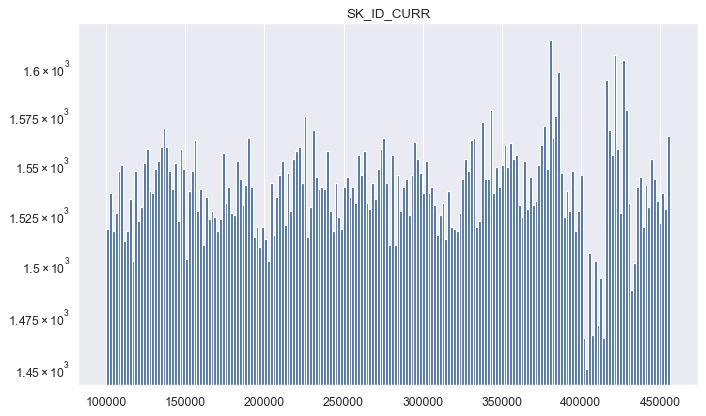

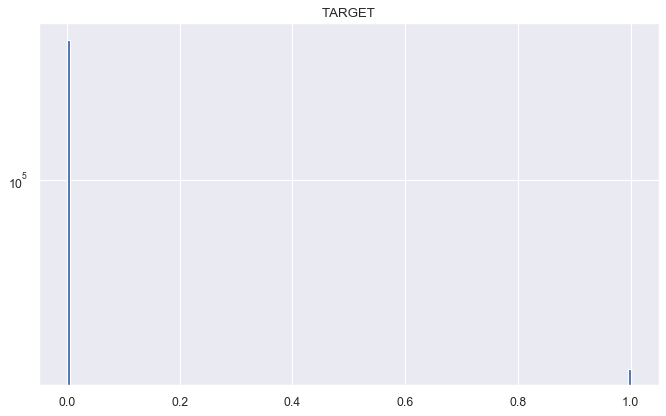

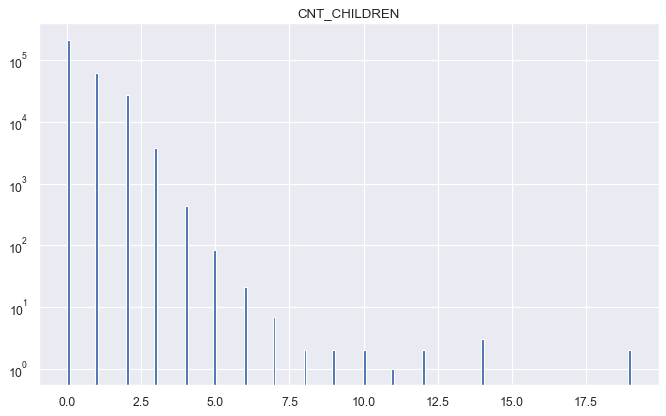

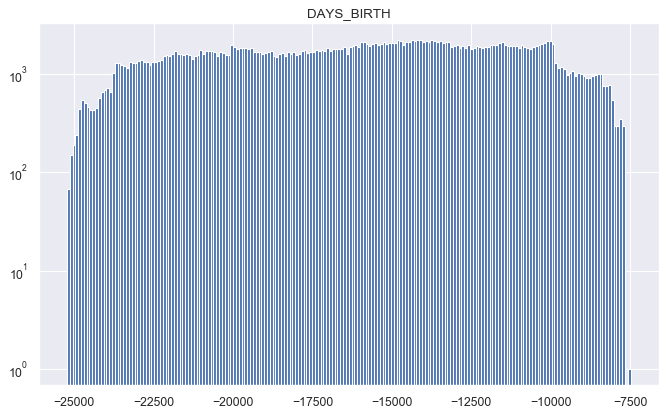

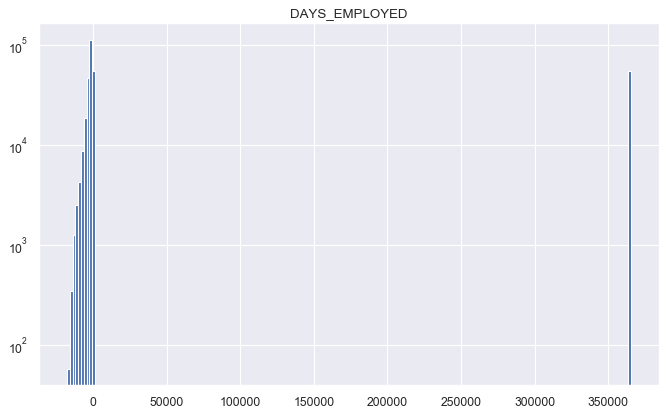

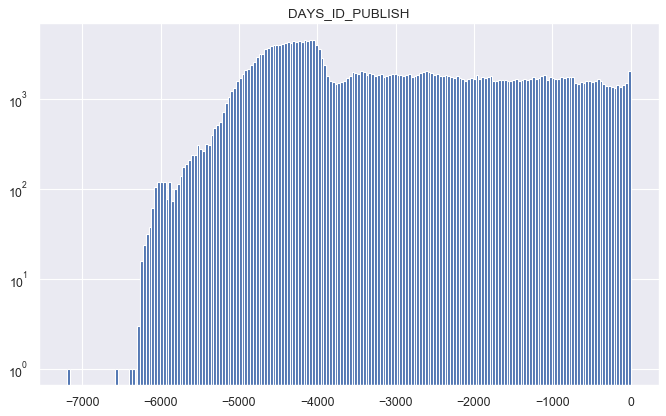

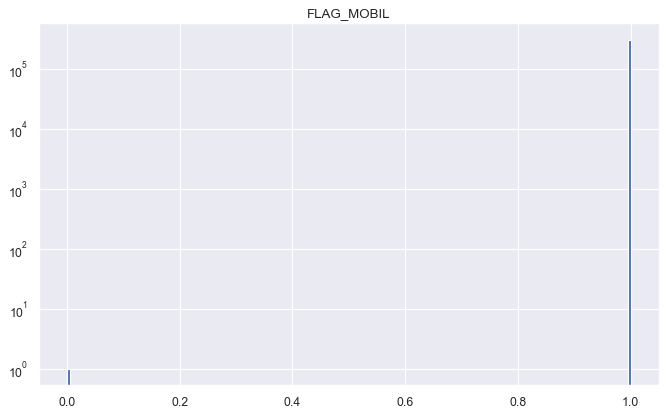

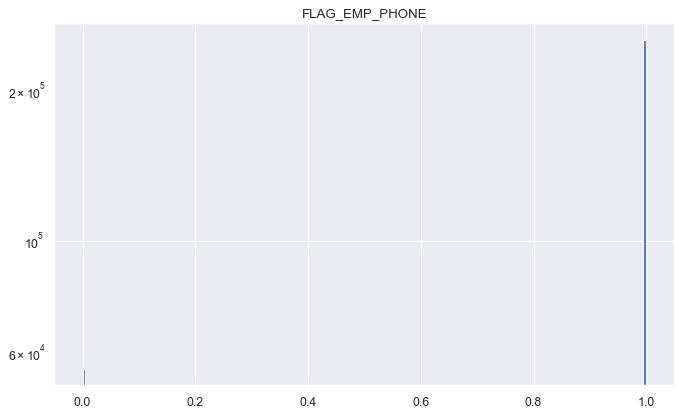

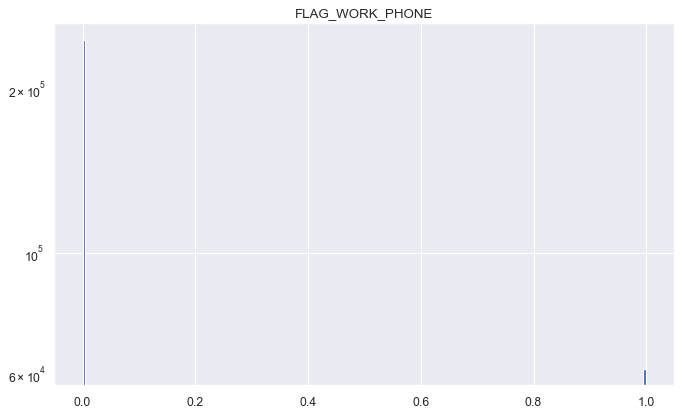

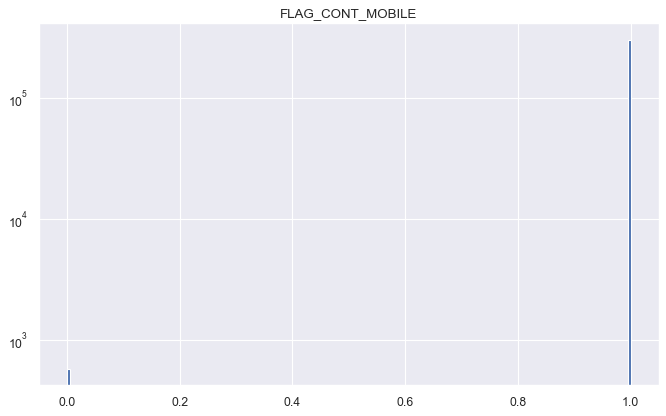

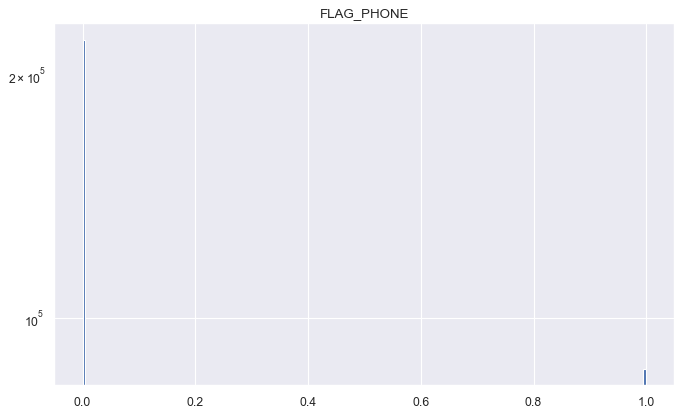

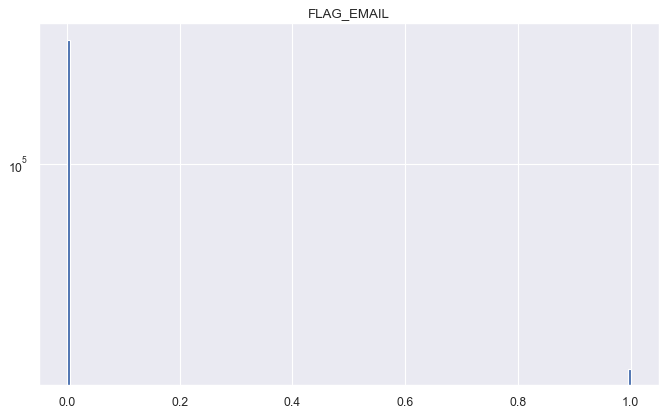

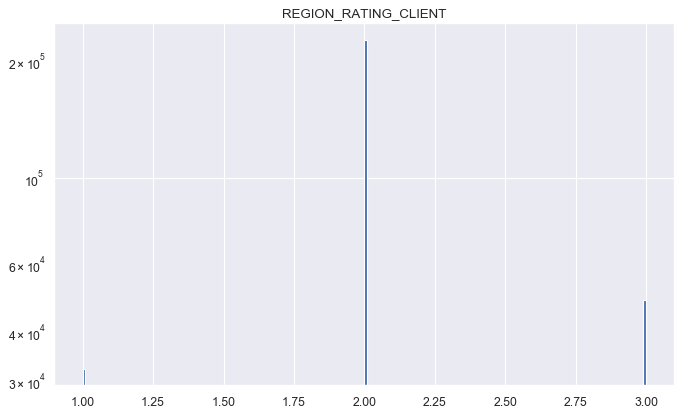

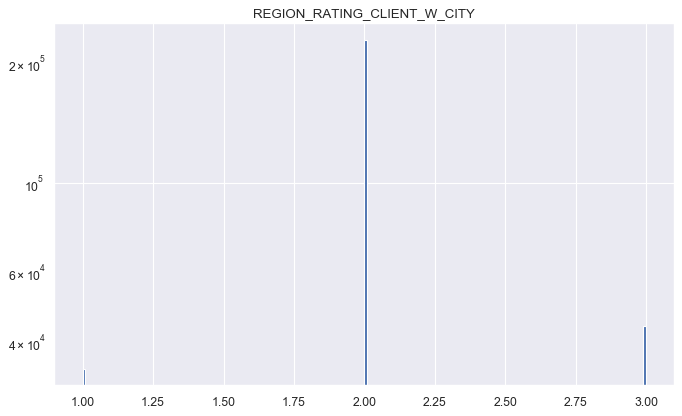

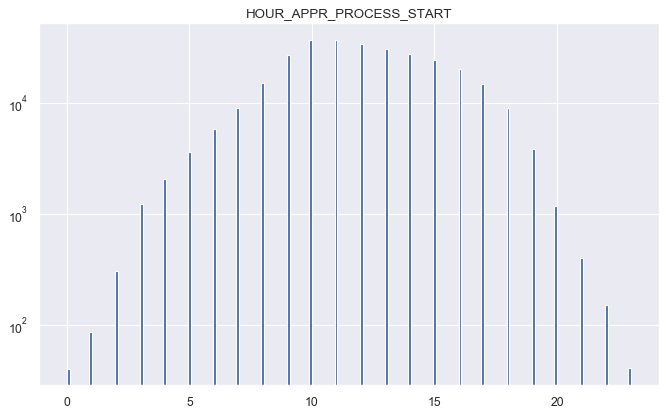

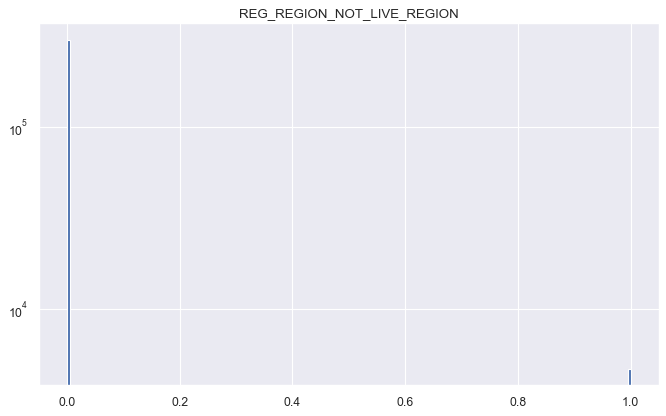

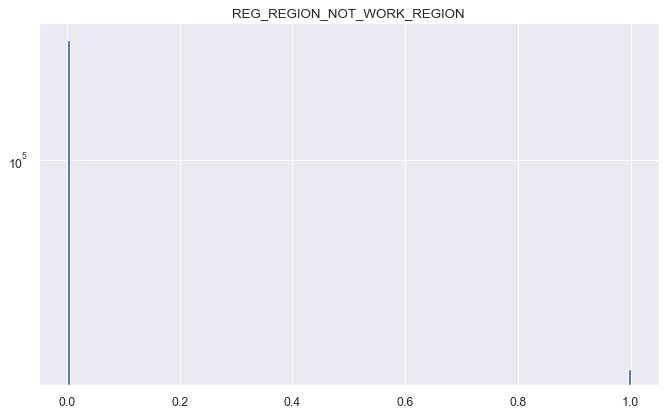

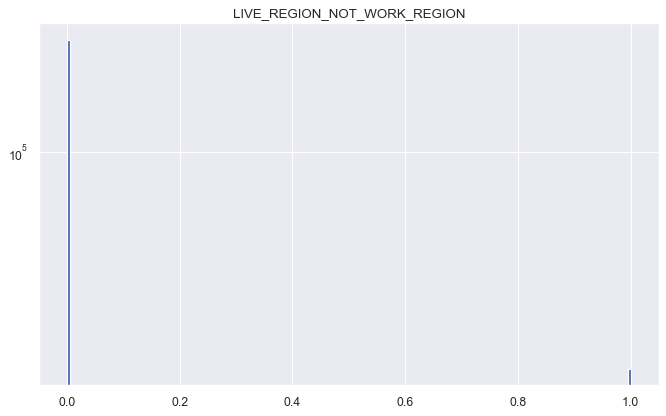

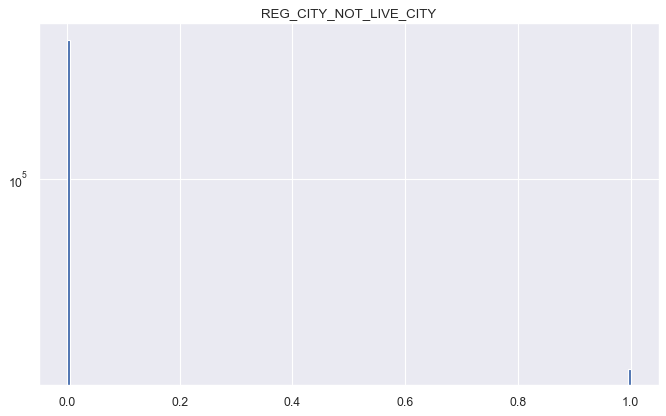

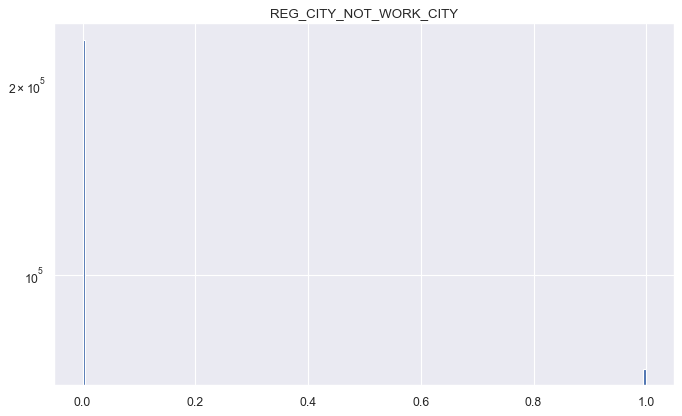

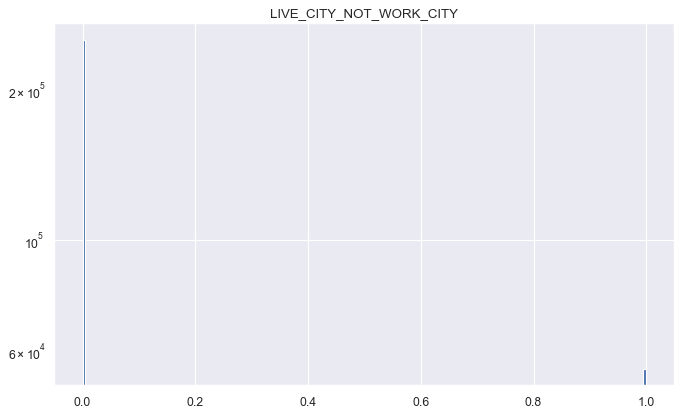

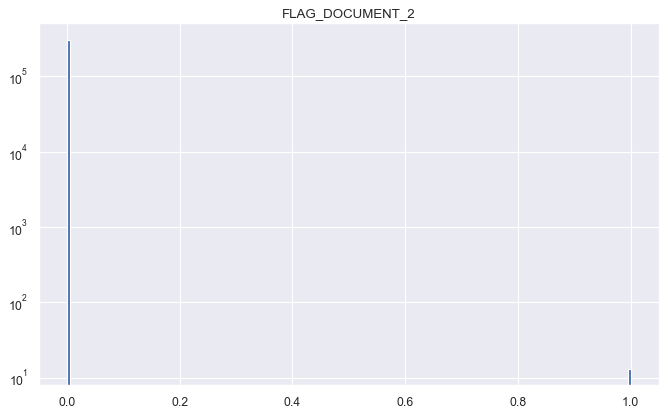

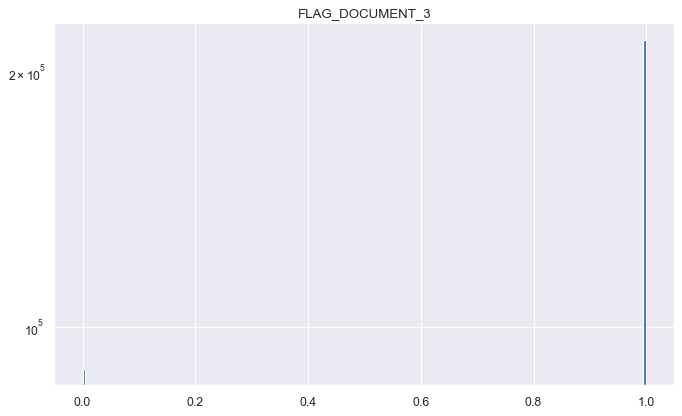

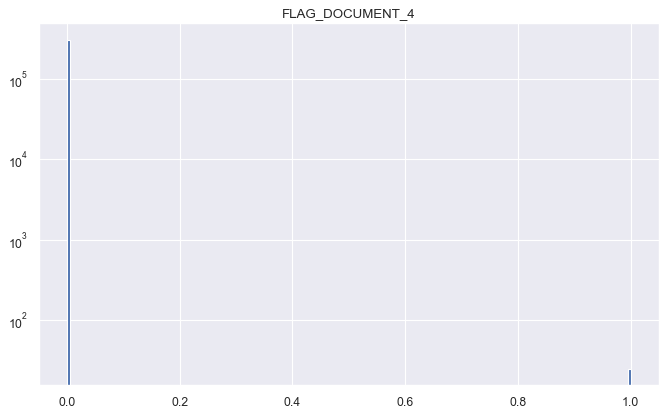

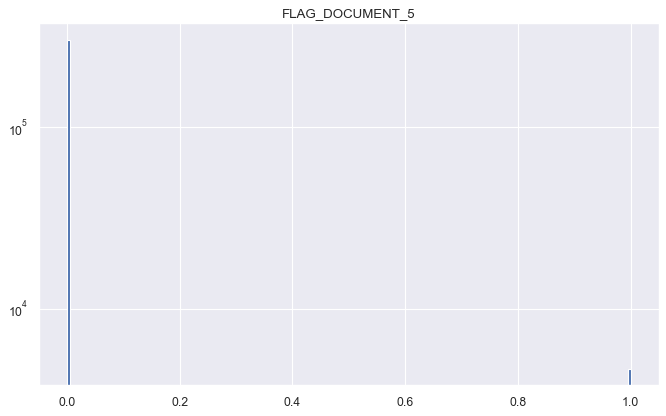

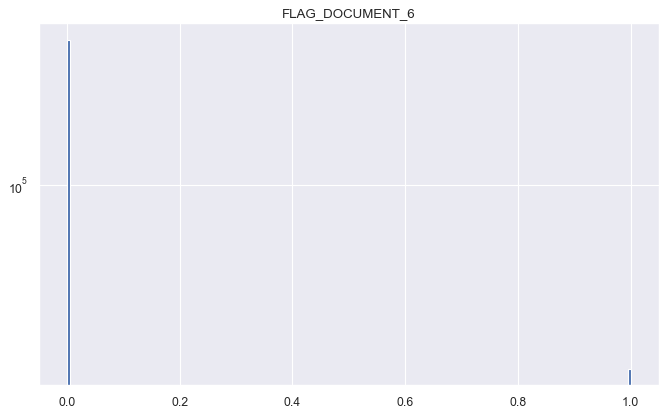

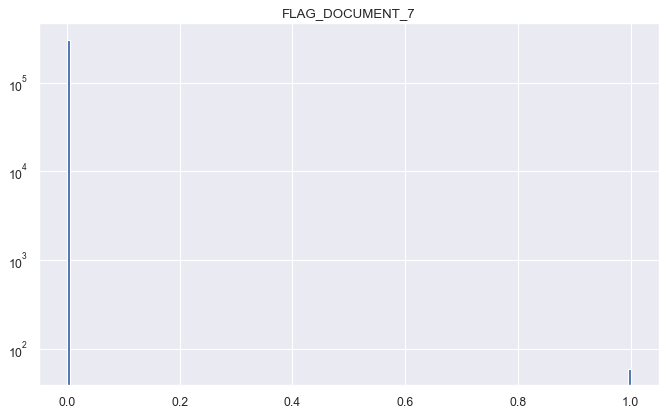

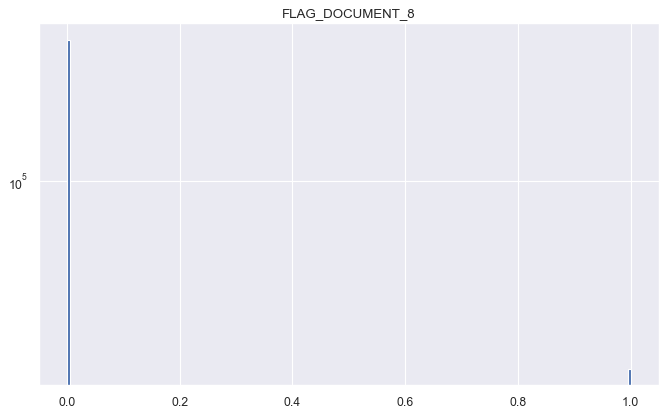

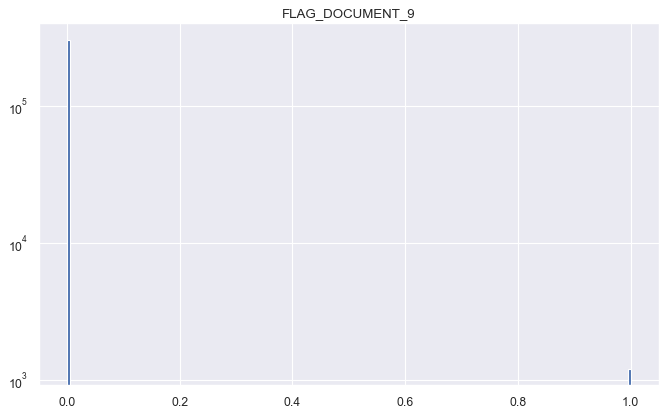

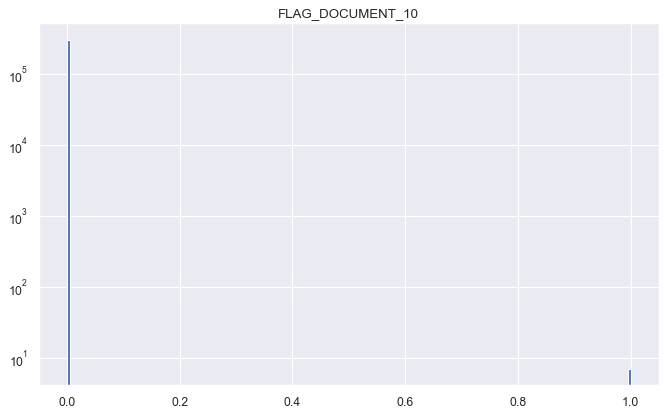

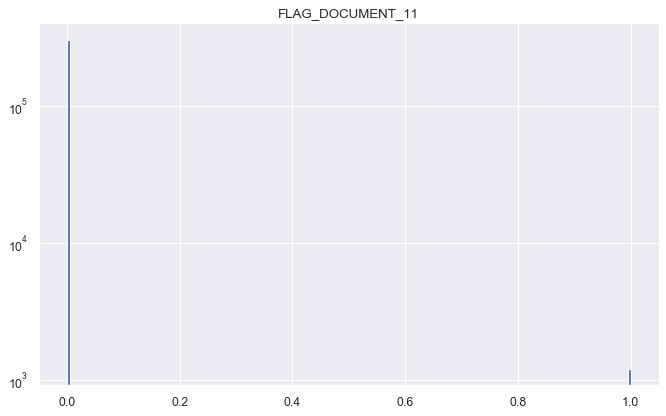

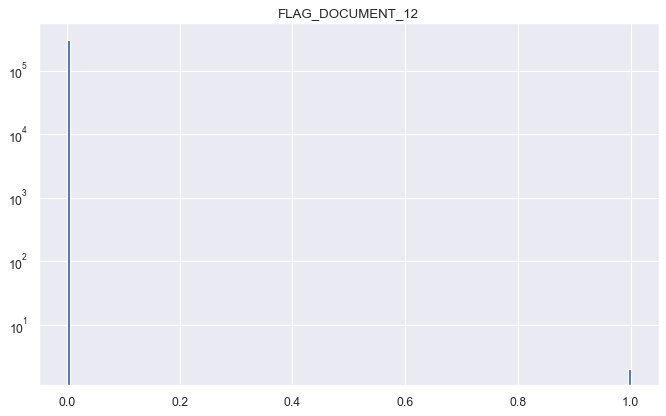

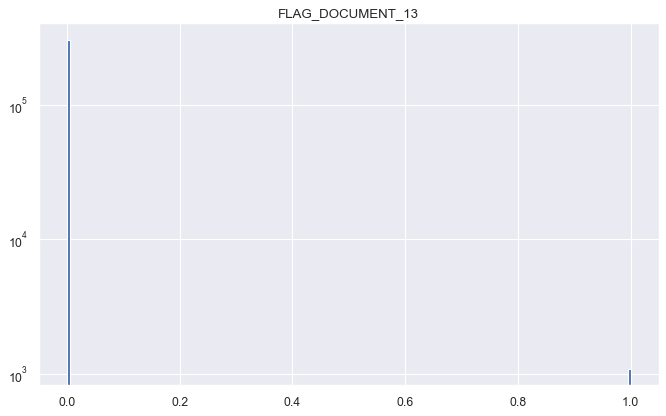

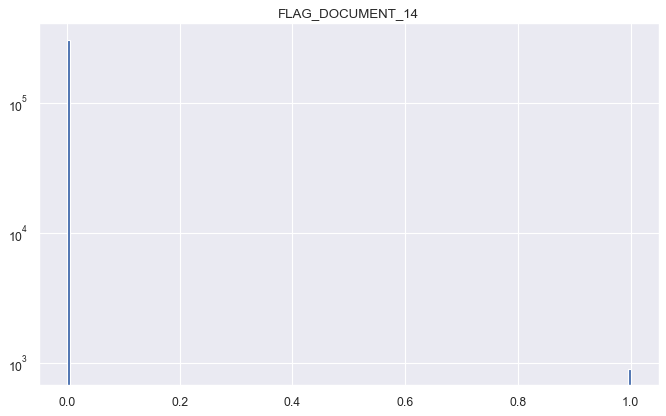

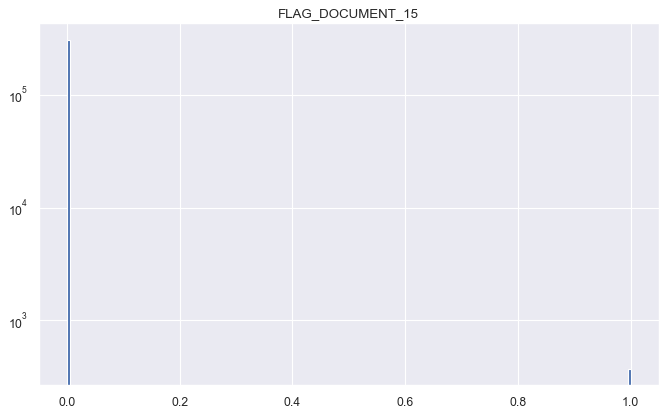

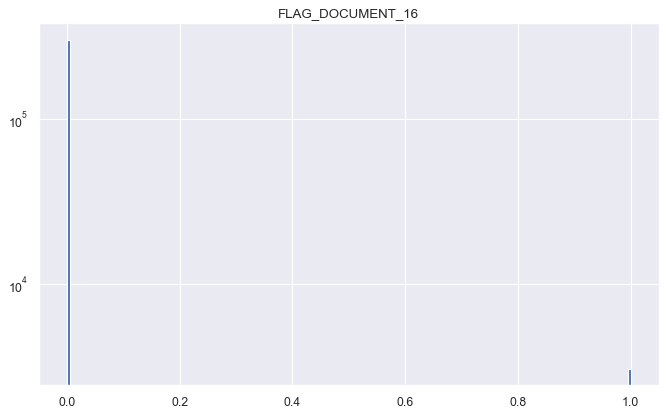

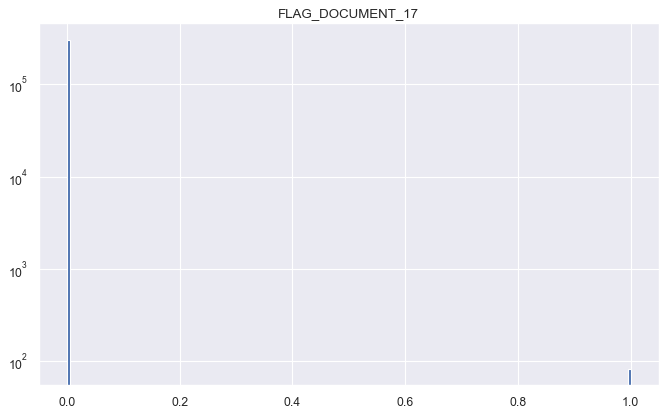

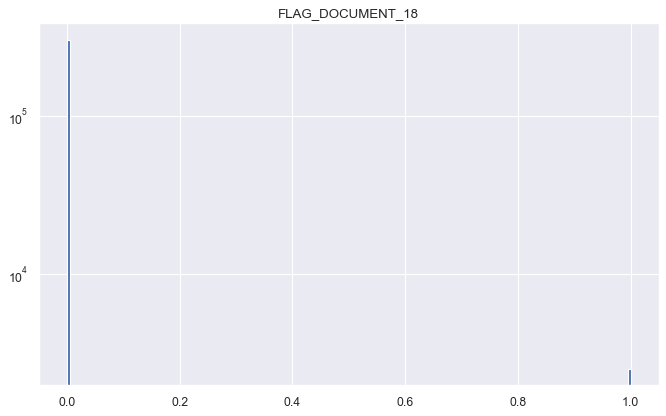

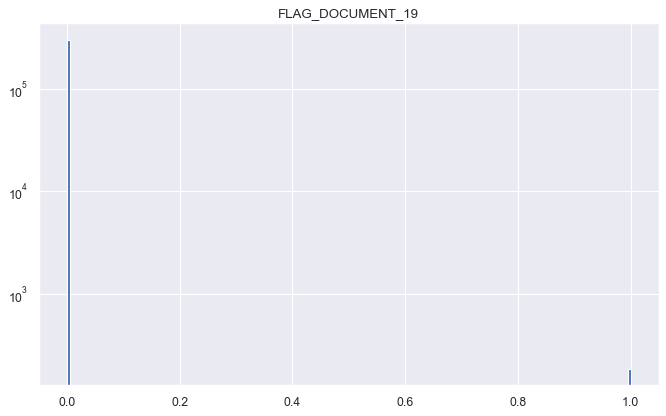

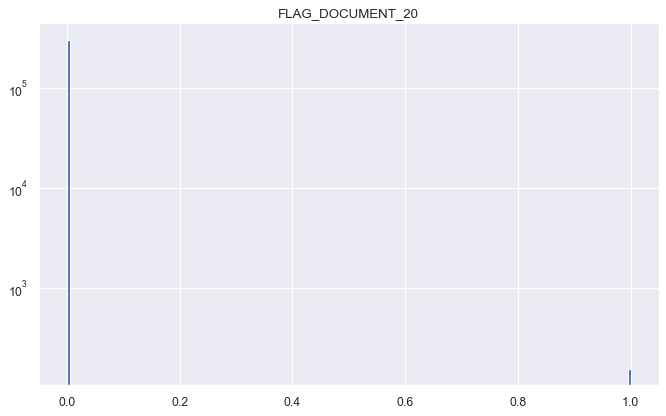

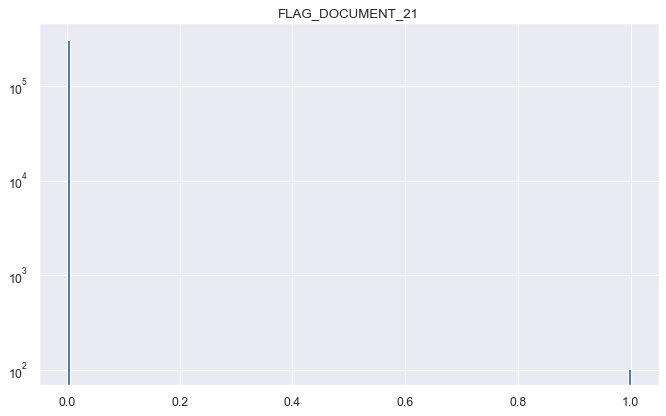

In [30]:
for column in data_int: # 類別型
    plt.figure(figsize=(10,6), dpi=80)
    plt.hist(train[column],bins=200,log=True)
    plt.title(column)

C:\Users\YEN32\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\YEN32\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\YEN32\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


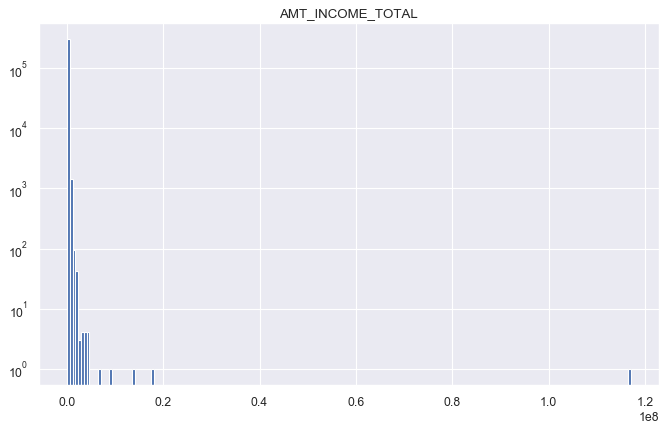

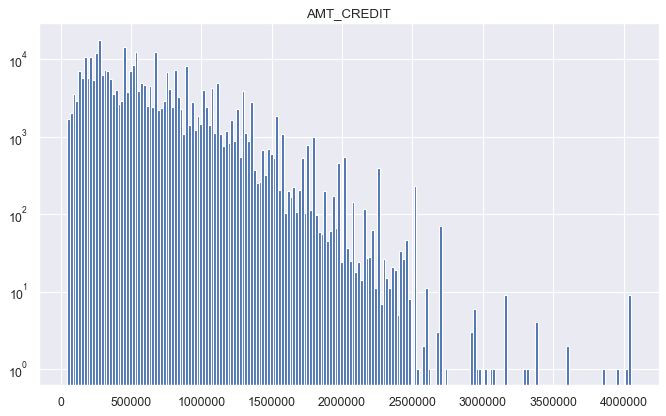

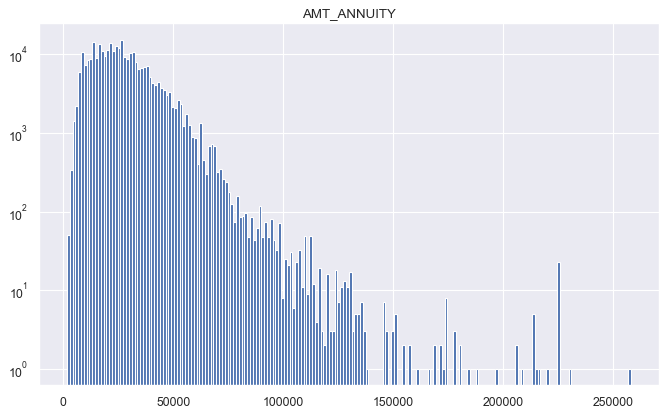

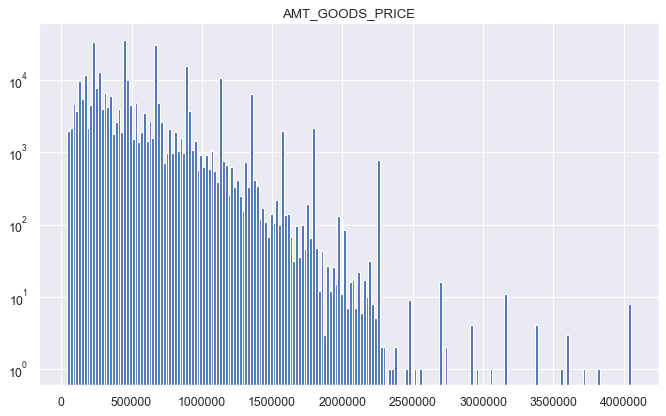

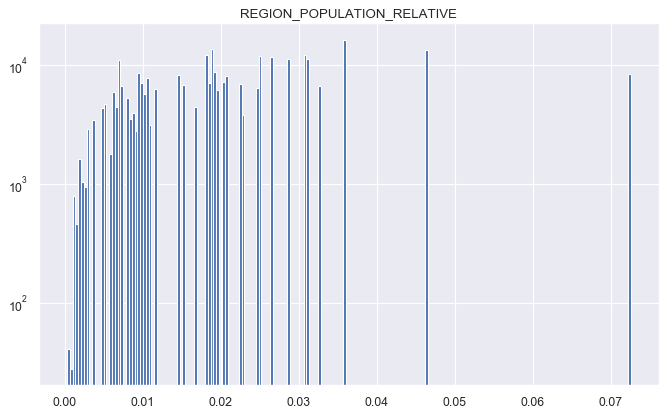

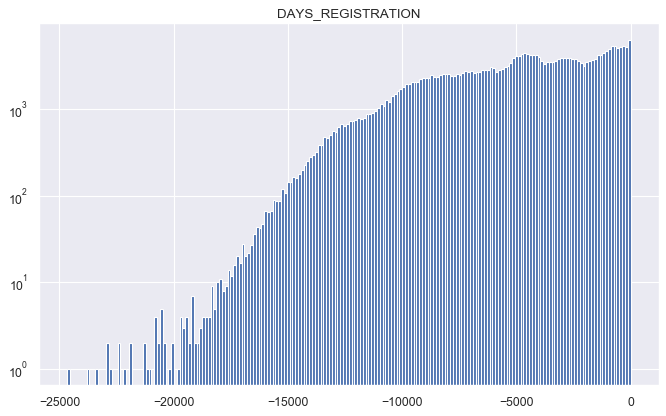

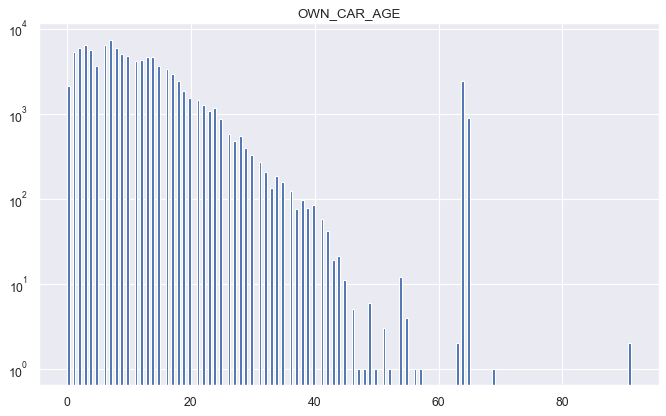

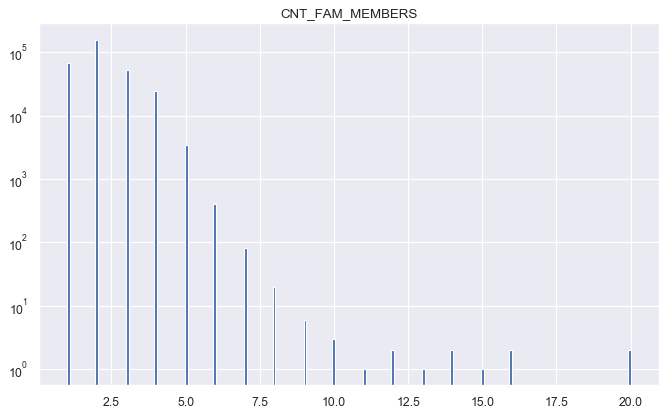

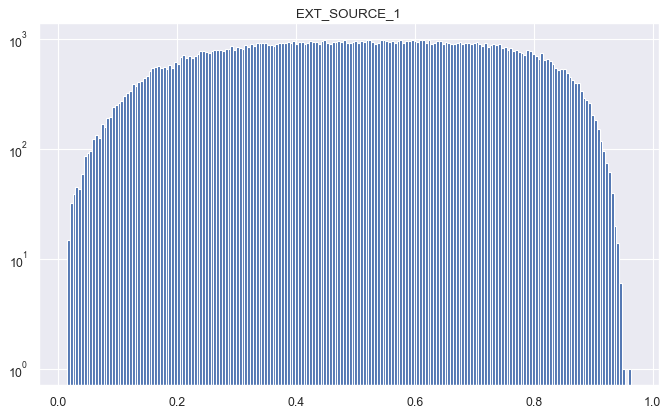

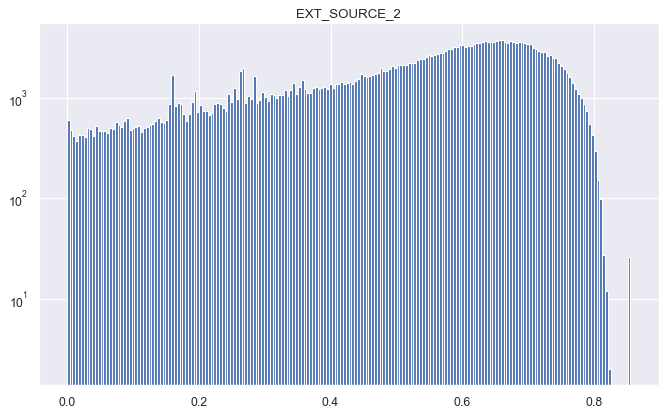

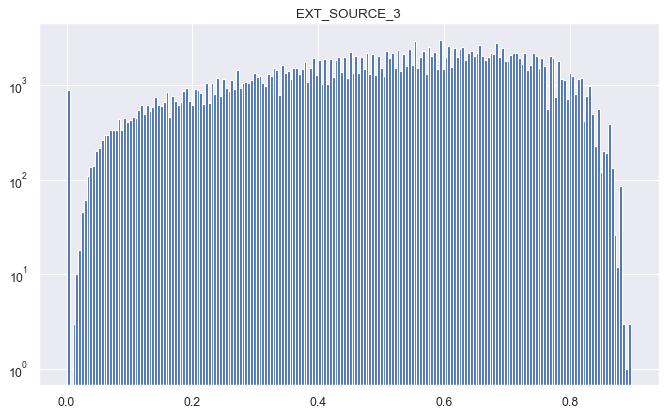

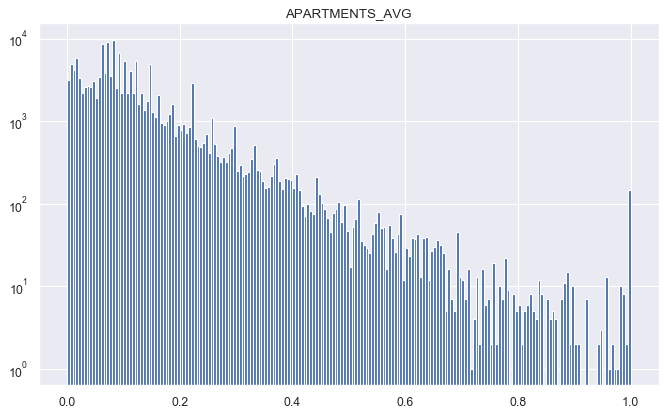

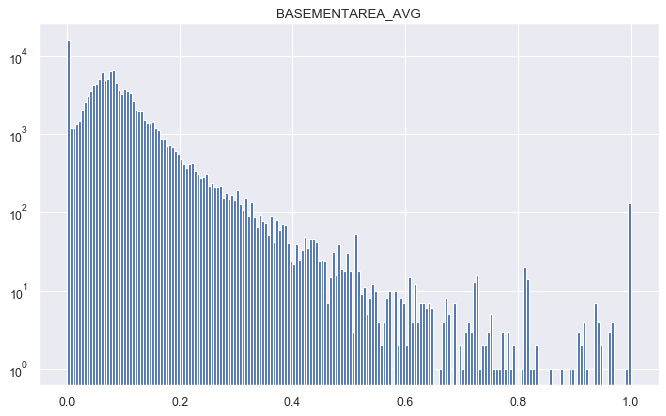

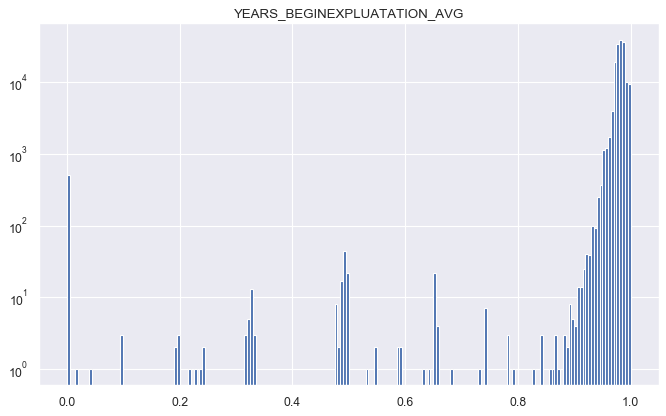

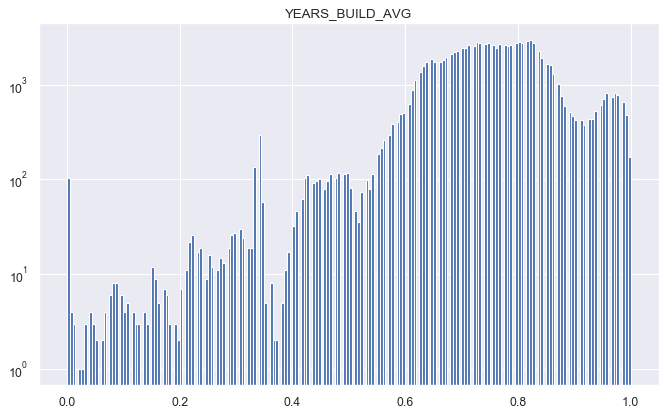

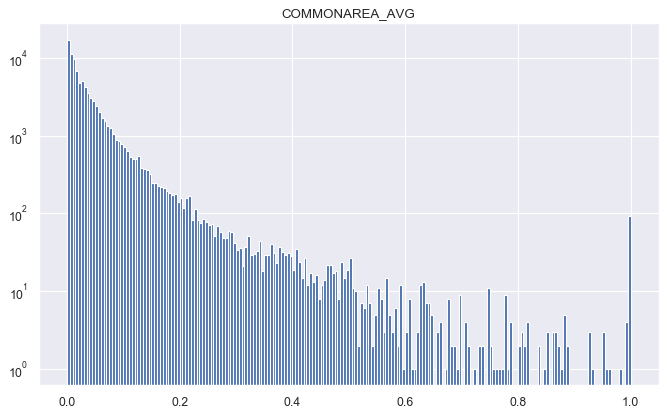

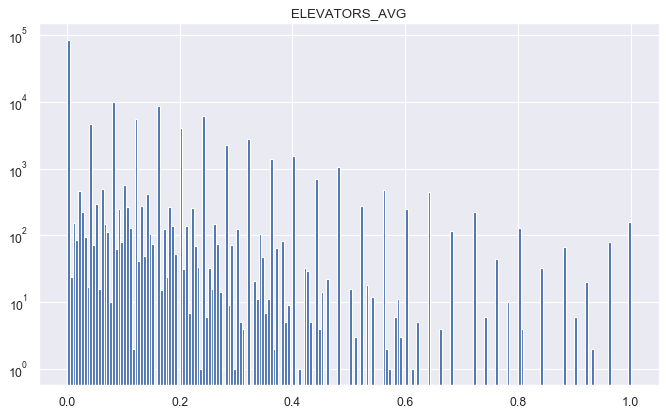

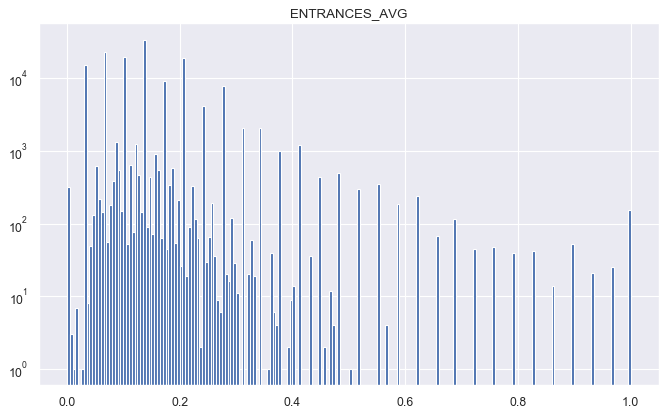

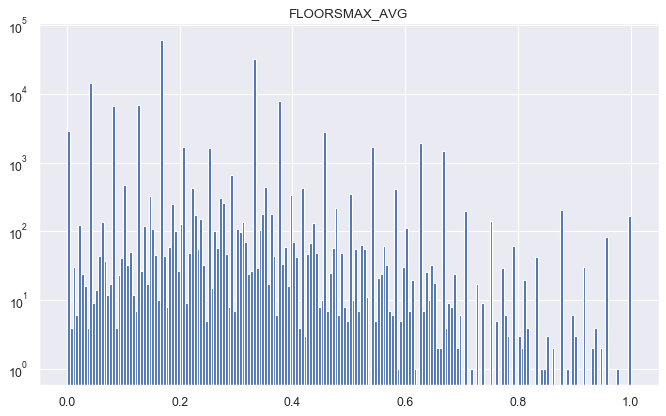

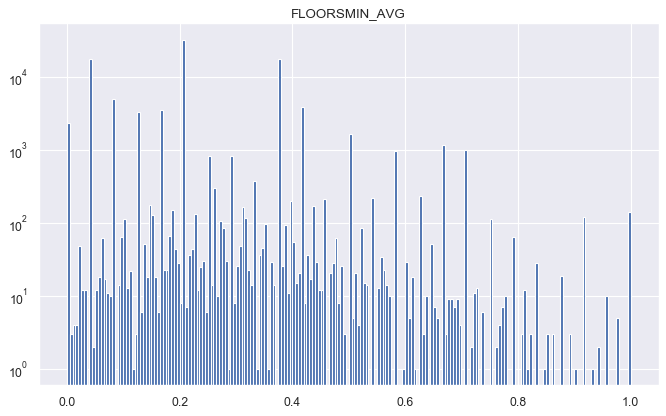

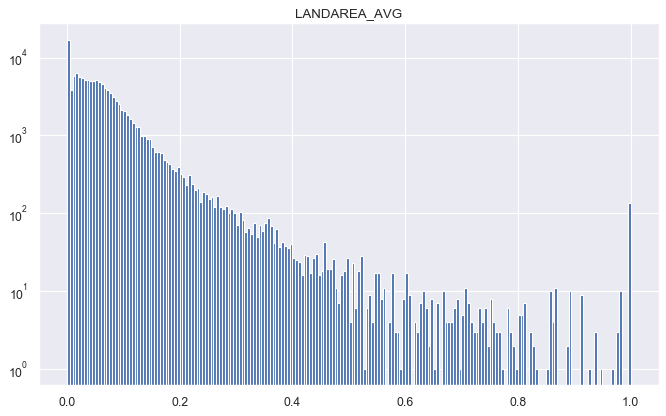

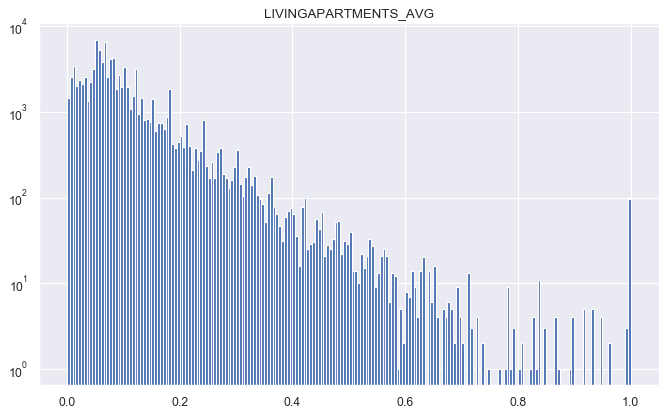

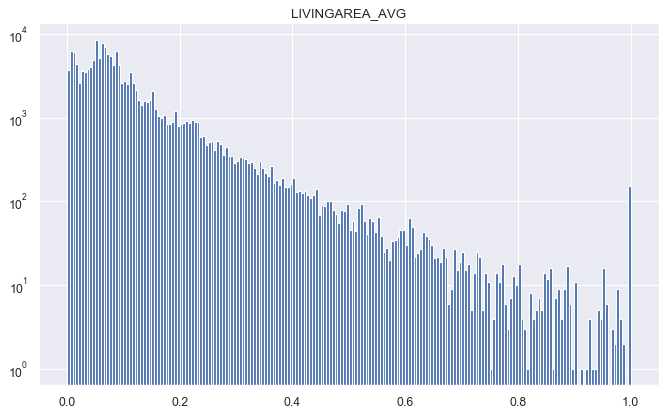

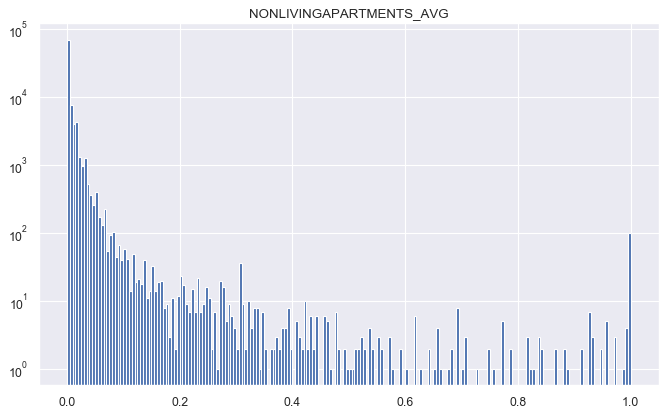

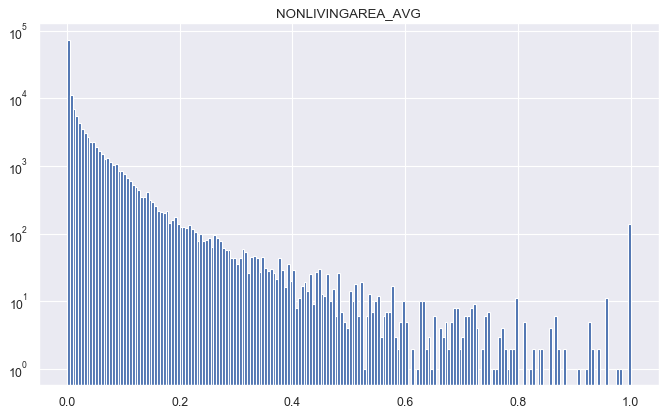

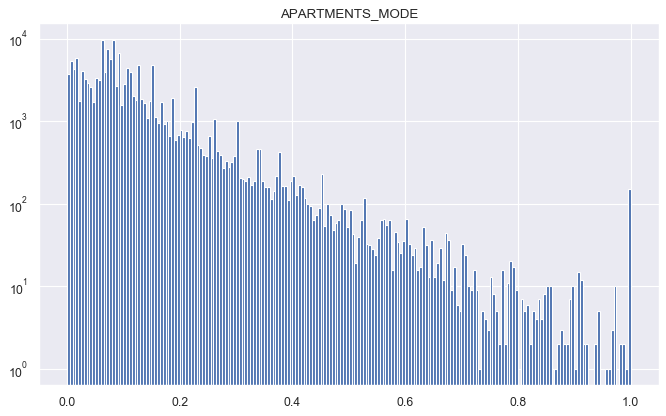

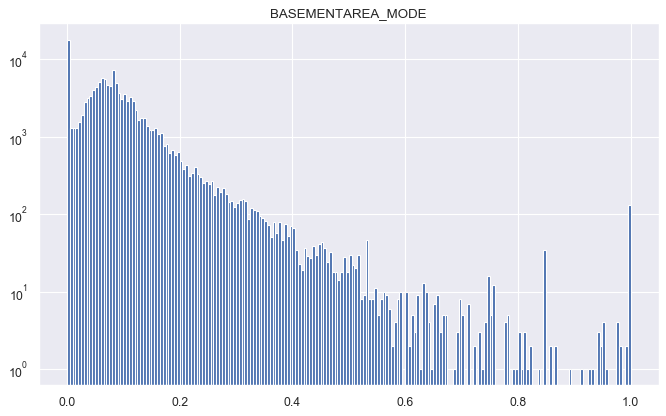

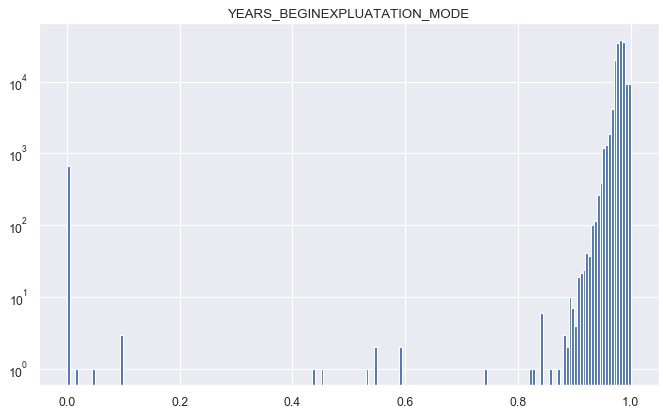

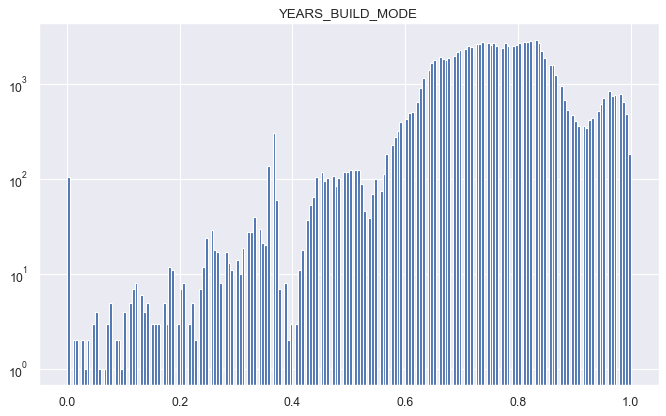

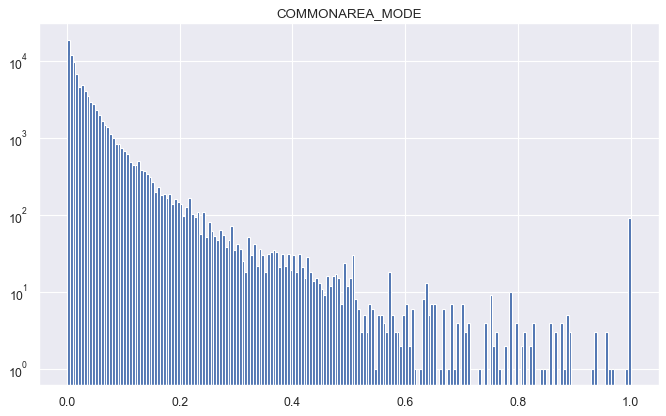

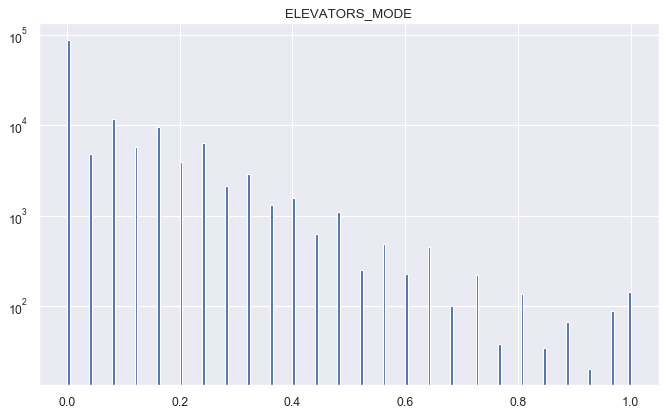

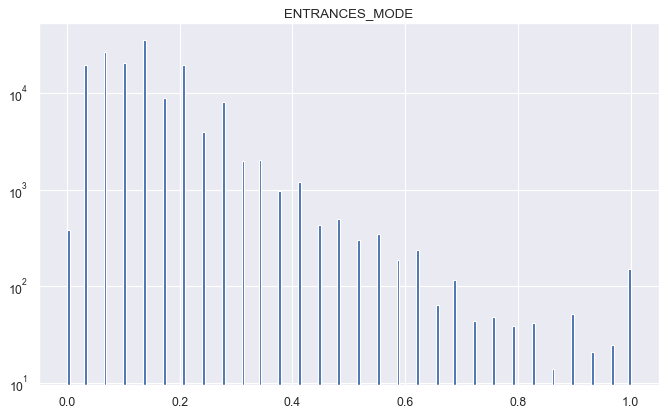

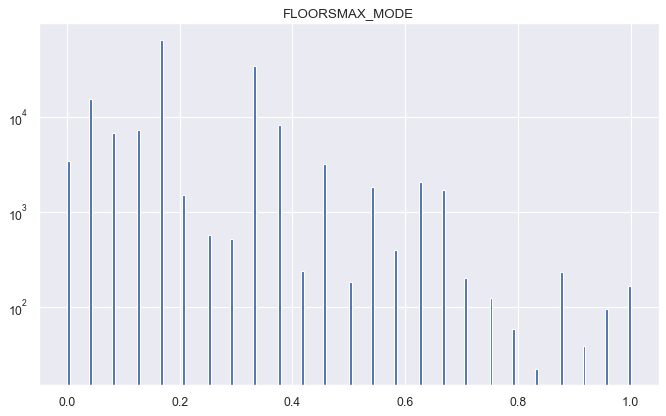

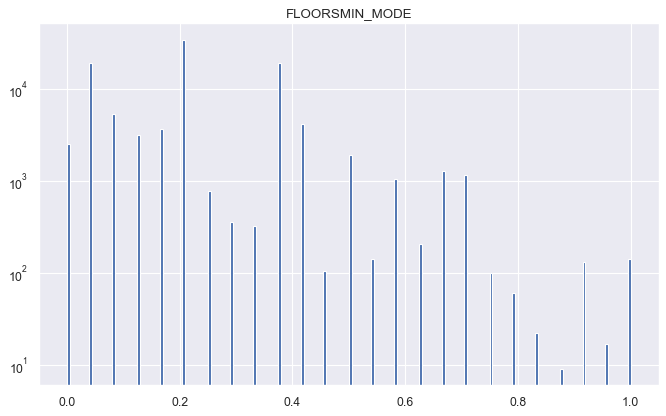

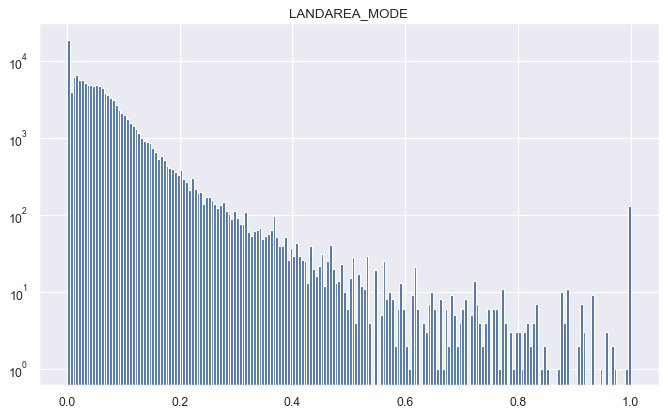

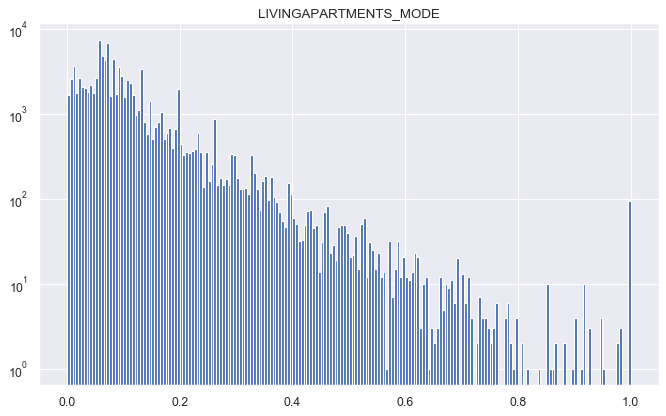

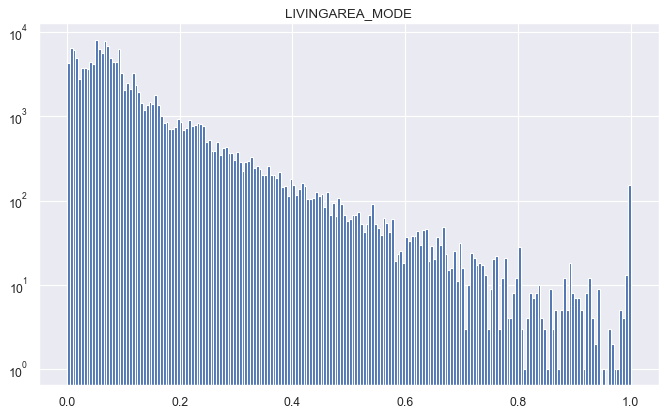

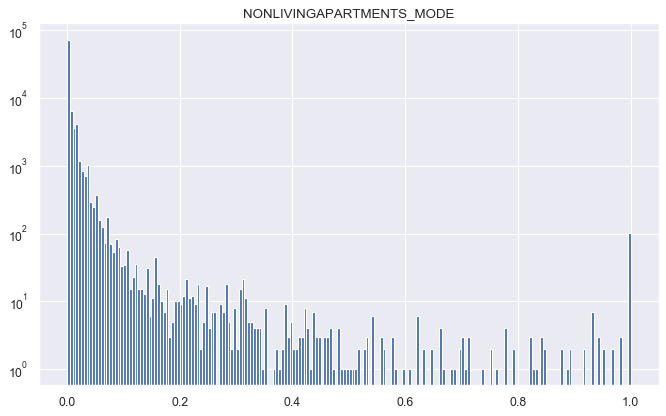

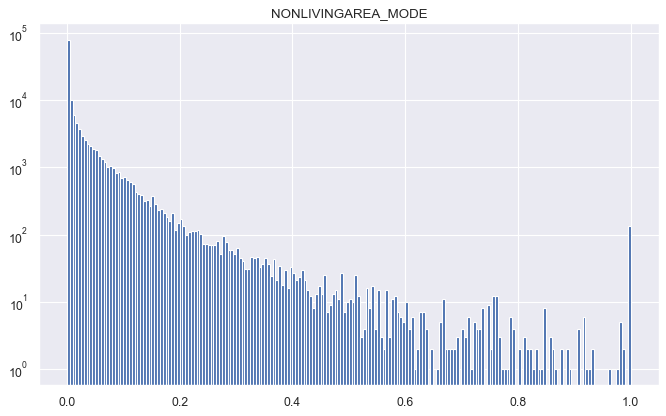

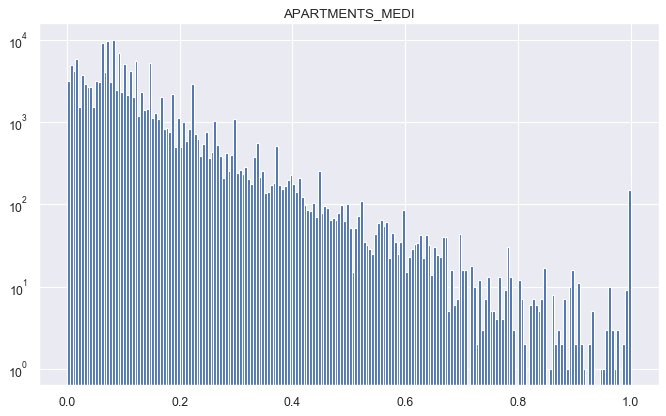

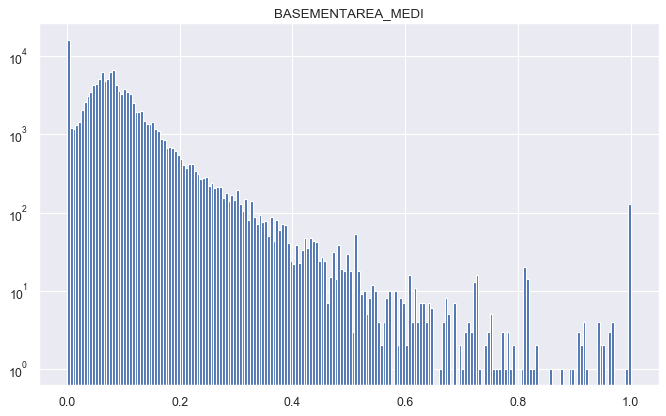

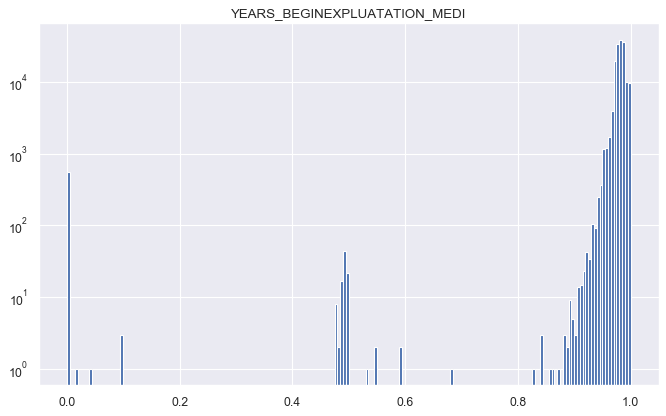

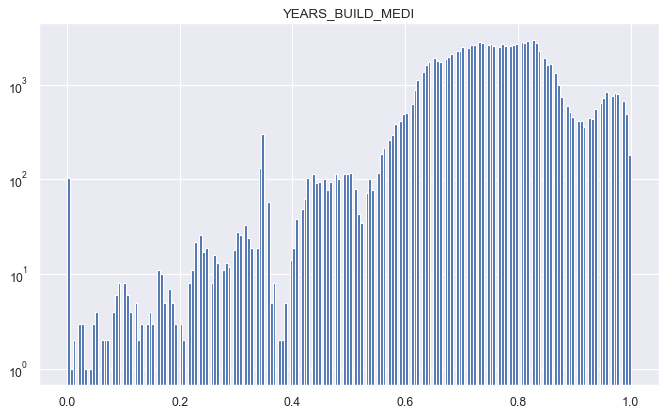

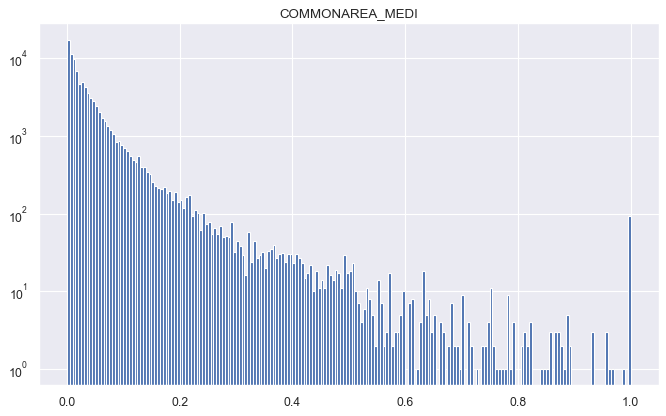

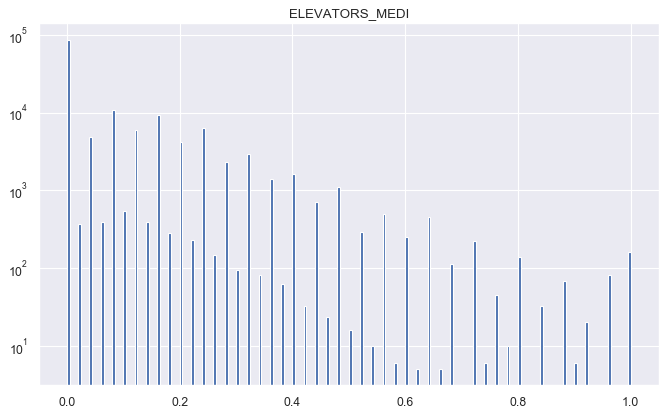

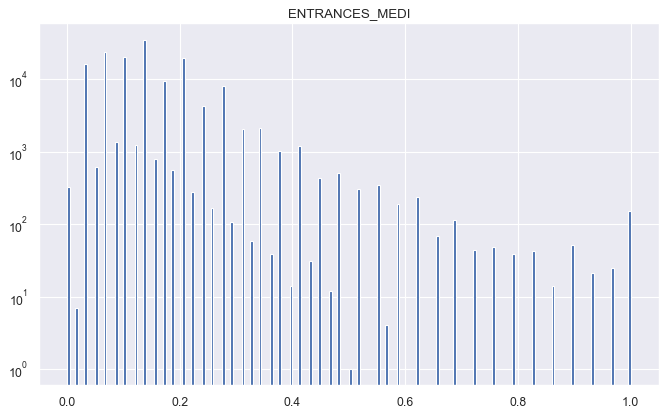

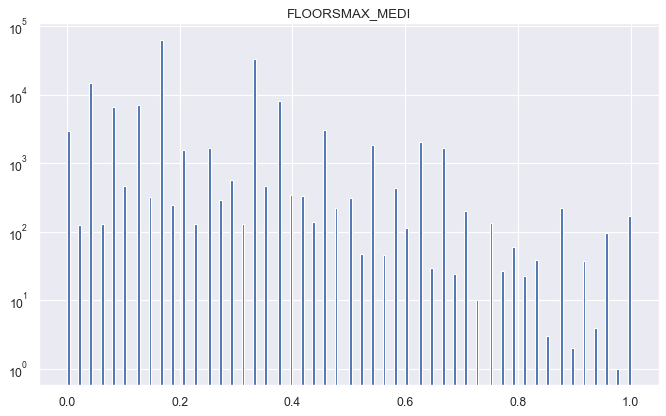

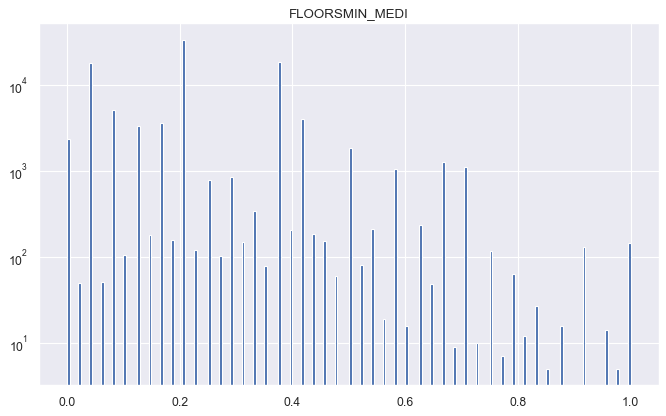

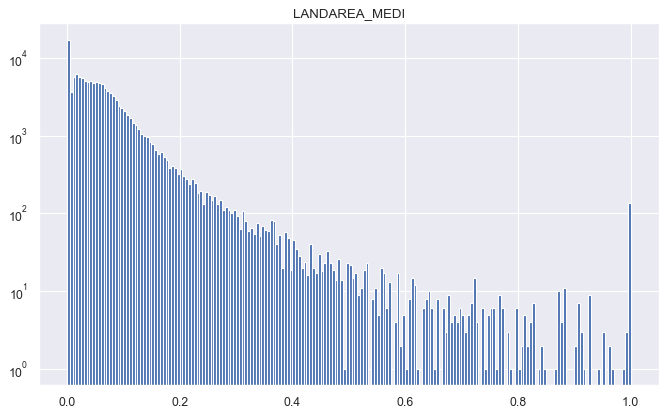

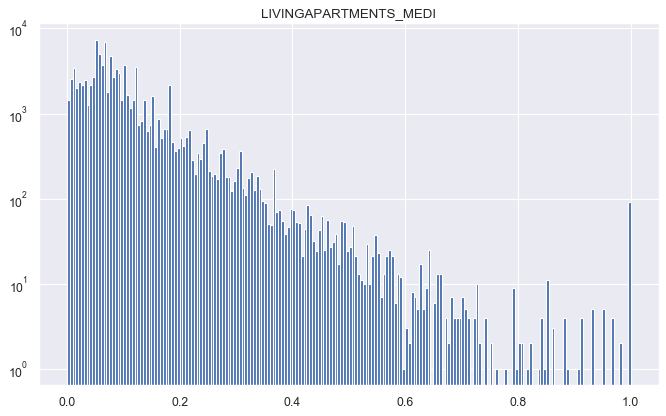

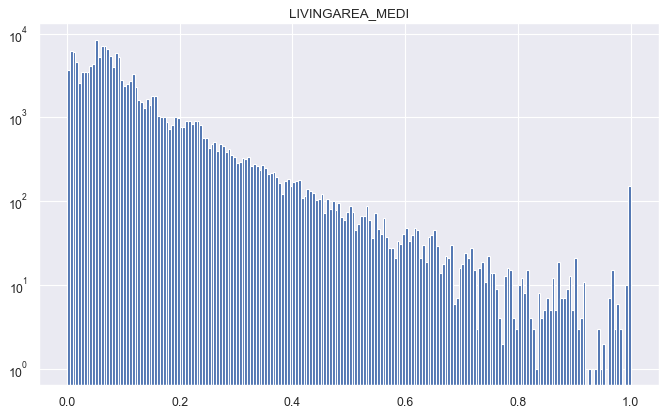

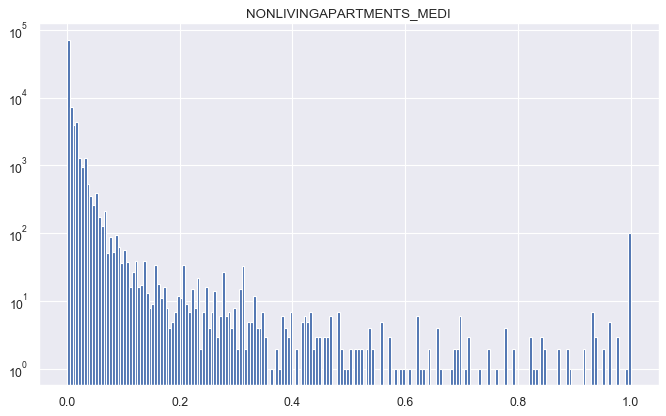

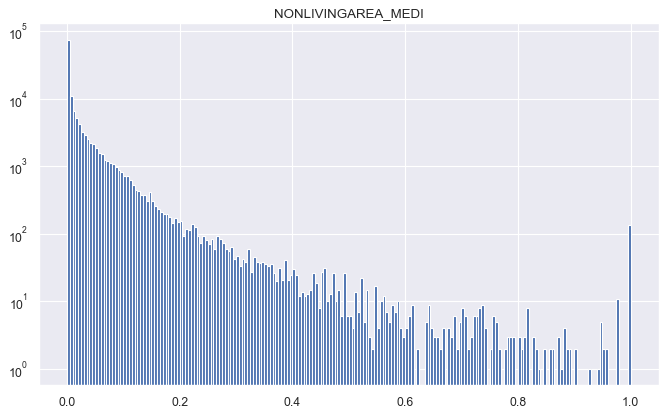

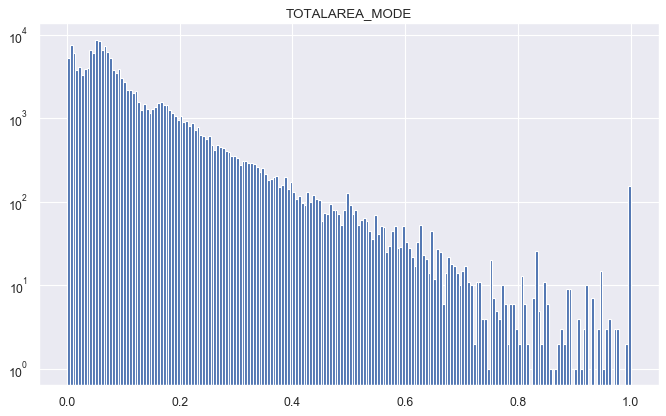

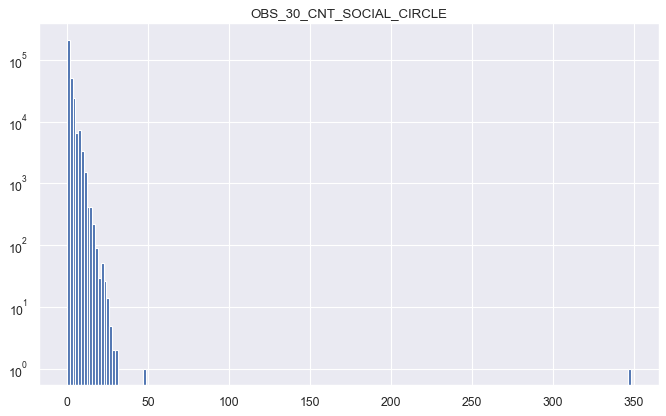

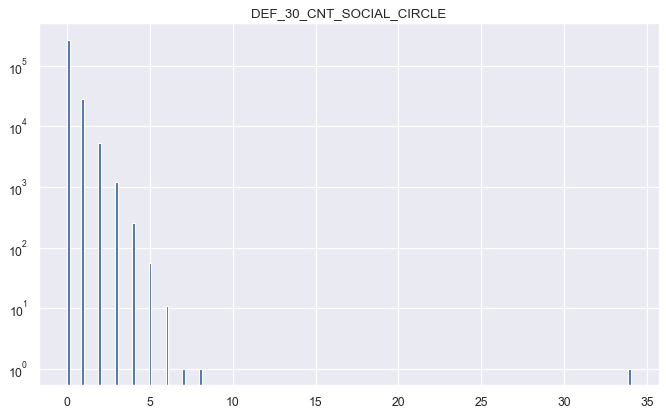

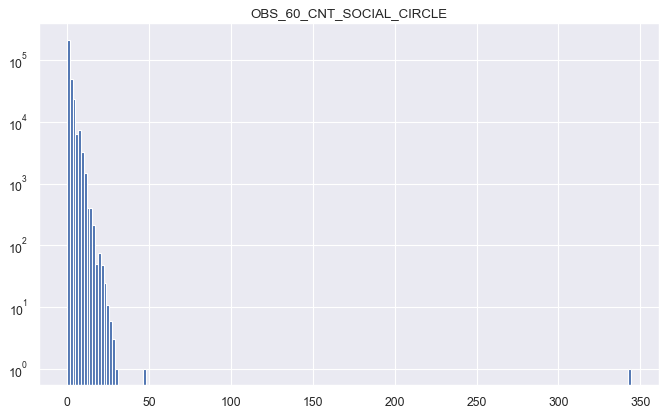

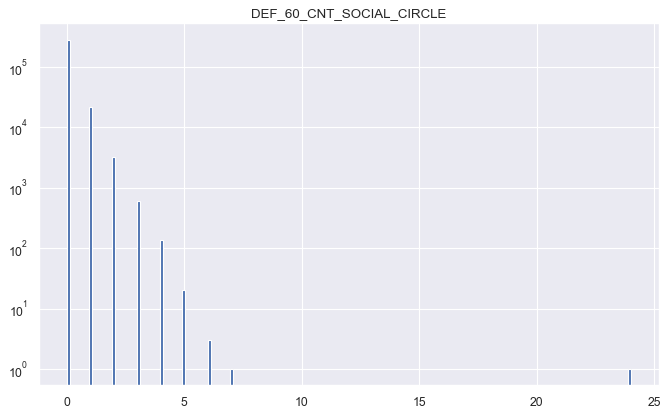

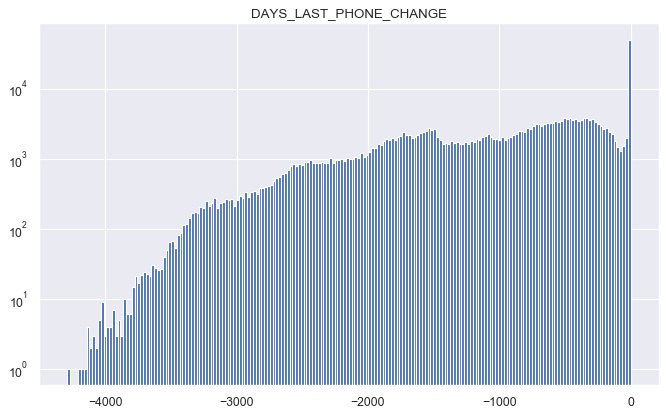

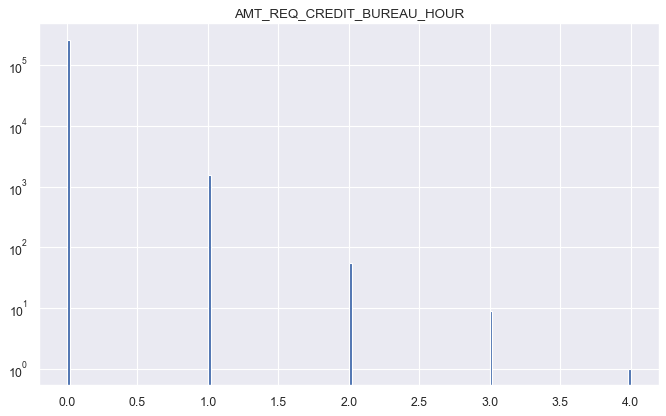

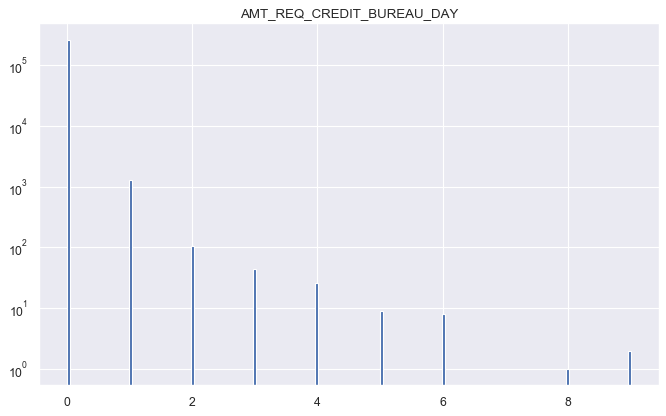

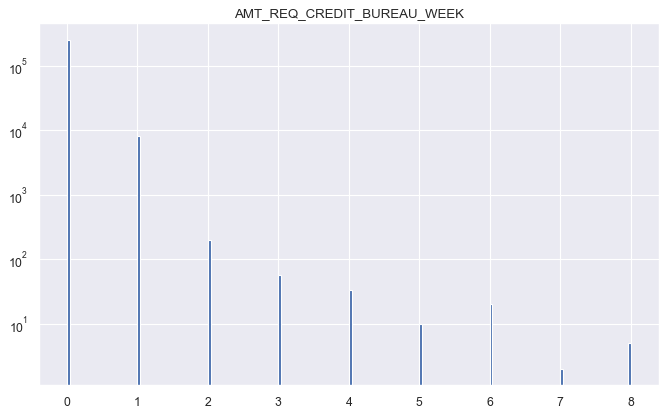

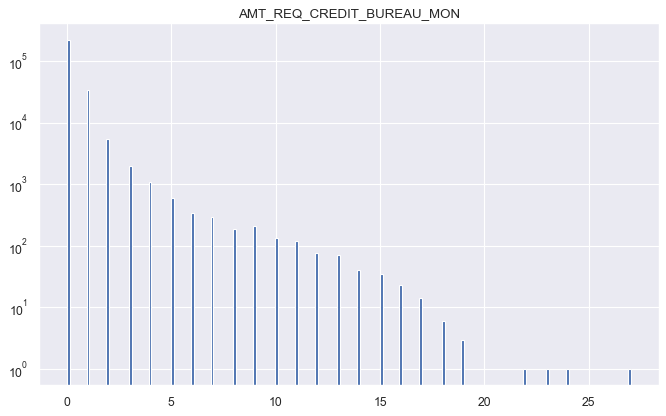

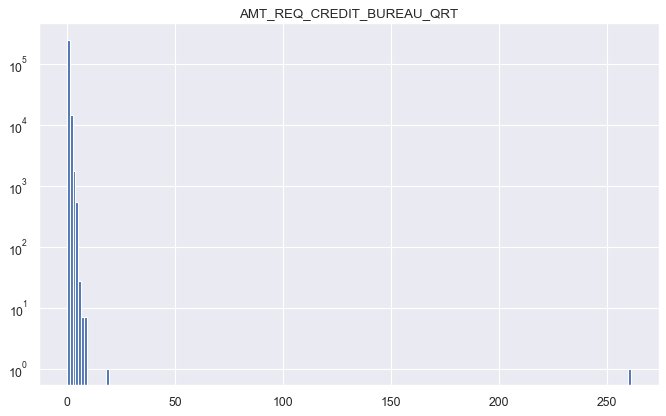

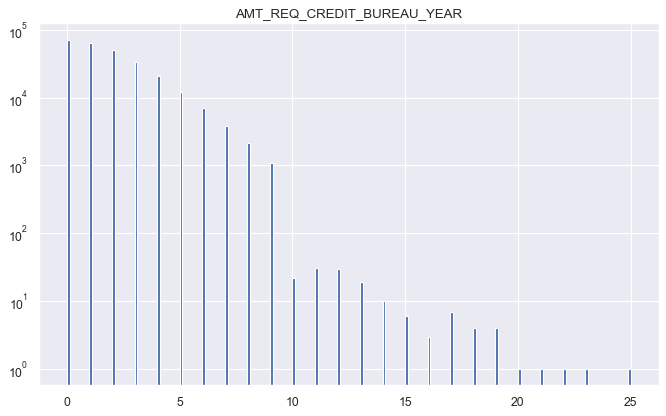

In [31]:
for column in data_float:
    plt.figure(figsize=(10,6), dpi=80)
    plt.hist(train[column],bins=200,log=True)
    plt.title(column)

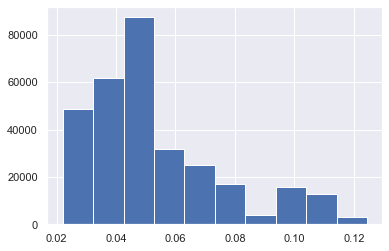

In [28]:
(train['AMT_ANNUITY']/train['AMT_CREDIT']).hist() # ANNUITY都小於CREDIT，合理

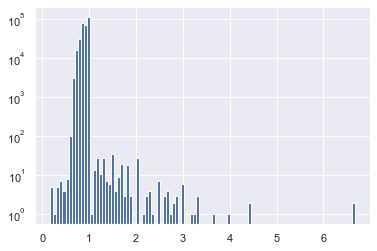

In [29]:
(train['AMT_GOODS_PRICE']/train['AMT_CREDIT']).hist(bins=100,log=True) # GOODS_PRICE超過CREDIT，不太理解

In [30]:
((train['AMT_GOODS_PRICE']/train['AMT_CREDIT']) > 1).sum()

260

GOODS_PRICE超過CREDIT只有260筆，考慮處理

## 處理空值

### 線性回歸測試

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [37]:
withAnnuity = train[(train['AMT_ANNUITY'].isna()==False) 
                    & (train['AMT_GOODS_PRICE'].isna()==False)
                    & (train['AMT_CREDIT'].isna()==False)]

In [38]:
assert withAnnuity['AMT_ANNUITY'].isna().sum()==0

In [39]:
noAnnuity = train[(train['AMT_ANNUITY'].isna()==True) # 這個好像沒用
                  & (train['AMT_GOODS_PRICE'].isna()==False) 
                  & (train['AMT_CREDIT'].isna()==False)]

In [40]:
train['AMT_ANNUITY'].isna().sum() # ANNUITY空值只有12個

12

In [41]:
predictAnnuity_X = noAnnuity[['AMT_GOODS_PRICE','AMT_CREDIT']].values # 這個好像沒用
predictAnnuity_X.shape[0] # 有12筆ANNUITY要預測

12

In [42]:
x = withAnnuity[['AMT_GOODS_PRICE','AMT_CREDIT']]
y = withAnnuity['AMT_ANNUITY']

In [43]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)  # 共分成3份資料 
val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5)

In [44]:
print('shape(train_x)=\t\t\t', train_x.shape)
print('shape(train_y)=\t\t\t', train_y.shape)
print('shape(val_x)=\t\t\t', val_x.shape)
print('shape(val_y)=\t\t\t', val_y.shape)
print('shape(test_x)=\t\t\t', test_x.shape)
print('shape(test_y)=\t\t\t', test_y.shape)

shape(train_x)=			 (215054, 2)
shape(train_y)=			 (215054,)
shape(val_x)=			 (46083, 2)
shape(val_y)=			 (46083,)
shape(test_x)=			 (46084, 2)
shape(test_y)=			 (46084,)


In [45]:
regressor = LinearRegression(n_jobs=2)
model = regressor.fit(train_x, train_y)

In [46]:
model.coef_ 

array([0.02305072, 0.00685781])

In [47]:
model.intercept_ 

10621.491010622733

In [48]:
pred_y = model.predict(val_x)
r2_score(val_y, pred_y)

0.6029740547015845

In [49]:
mean_absolute_error(val_y, pred_y)

6491.829728585297

### KNN測試

In [50]:
from sklearn.neighbors import KNeighborsRegressor

In [51]:
scaler = StandardScaler()
scaler = scaler.fit(train_x)  # 算出mean, std

train_x = scaler.transform(train_x) # 利用mean, std來將資料變成標準常態分佈
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [65]:
test_x

array([[ 2.19830779,  1.86647912],
       [-0.84800044, -0.8558725 ],
       [-0.96985277, -1.04153823],
       ...,
       [-0.70177765, -0.63071367],
       [-0.2387388 , -0.01612657],
       [ 0.73607984,  0.92293934]])

In [66]:
import warnings
warnings.filterwarnings("ignore")

n = 21
MAE = 3904.4471536713645
R^2 = 0.7998211472570931
n = 22
MAE = 3895.5254877647876
R^2 = 0.8003934951680552
n = 23
MAE = 3887.5093070129356
R^2 = 0.8003203076770735
n = 24
MAE = 3885.661552936034
R^2 = 0.8003698065710321
n = 25
MAE = 3882.0381622595223
R^2 = 0.8005957226827575
n = 26
MAE = 3888.88634210576
R^2 = 0.8008777901346099
n = 27
MAE = 3888.5672449330673
R^2 = 0.801181109213325
n = 28
MAE = 3892.12220875898
R^2 = 0.8014017488809222
n = 29
MAE = 3886.8435903744553
R^2 = 0.8019517311729137
n = 30
MAE = 3896.246811801758
R^2 = 0.8020905649632504
n = 31
MAE = 3889.8324603487627
R^2 = 0.8020789874338432
n = 32
MAE = 3887.6213279316444
R^2 = 0.8018430810802678
n = 33
MAE = 3889.212987582737
R^2 = 0.8019278719488084
n = 34
MAE = 3883.108919638417
R^2 = 0.8020955906447531
n = 35
MAE = 3886.4113391863257
R^2 = 0.8022897429360927
n = 36
MAE = 3880.682486689136
R^2 = 0.802276562052495
n = 37
MAE = 3883.1875866455134
R^2 = 0.8025224599456855
n = 38
MAE = 3879.4047707116038
R^2 = 0.80

n = 166
MAE = 3871.7271257989623
R^2 = 0.8029409880369551
n = 167
MAE = 3872.4832839502697
R^2 = 0.8029049665761289
n = 168
MAE = 3872.5393681151854
R^2 = 0.8029226119328741
n = 169
MAE = 3871.6799462294634
R^2 = 0.8029039136111955
n = 170
MAE = 3873.109649221674
R^2 = 0.8028857153918219
n = 171
MAE = 3871.8682492974376
R^2 = 0.802845102131302
n = 172
MAE = 3872.1674592148192
R^2 = 0.8028844154528155
n = 173
MAE = 3871.5543662077716
R^2 = 0.8028978298295204
n = 174
MAE = 3871.2423439594413
R^2 = 0.8028998536780925
n = 175
MAE = 3870.4339160088466
R^2 = 0.8028988589335384
n = 176
MAE = 3870.193343529424
R^2 = 0.8028798812283618
n = 177
MAE = 3871.1705821857554
R^2 = 0.8028577308186589
n = 178
MAE = 3872.0849664069374
R^2 = 0.8028405823250612
n = 179
MAE = 3871.8796038778937
R^2 = 0.8027970765720841
n = 180
MAE = 3872.0557018047857
R^2 = 0.8027784761753031
n = 181
MAE = 3872.6103523310467
R^2 = 0.8027757335026018
n = 182
MAE = 3874.7268048429805
R^2 = 0.8027913184721792
n = 183
MAE = 387

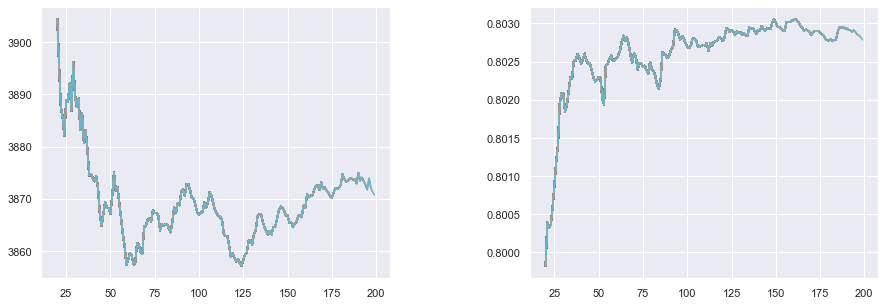

In [67]:
MAE = []  # 找參數，決定使用125個鄰居
R2 = []
ii = []
fig , ax = plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(wspace=0.4)
for i in range(20,200):
    neigh = KNeighborsRegressor(n_neighbors=i+1,weights='distance')
    neigh.fit(train_x, train_y)
    pred_y = neigh.predict(val_x)
    print(f'n = {i+1}')
    print(f'MAE = {mean_absolute_error(val_y, pred_y)}')
    print(f'R^2 = {r2_score(val_y, pred_y)}')
    ii.append(i)
    MAE.append(mean_absolute_error(val_y, pred_y))
    R2.append(r2_score(val_y, pred_y))
    plt.subplot(1,2,1)
    plt.plot(ii,MAE) 
    plt.subplot(1,2,2)
    plt.plot(ii,R2)

warnings.filterwarnings("default")

In [68]:
neigh = KNeighborsRegressor(n_neighbors=125,weights='distance')
neigh.fit(train_x, train_y)
pred1_y = neigh.predict(val_x)

In [69]:
pred1_y = neigh.predict(val_x)

In [70]:
mean_absolute_error(val_y, pred1_y)

3857.127136743829

In [71]:
r2_score(val_y, pred1_y)

0.8028879110860573

In [72]:
pred2_y = neigh.predict(test_x)

In [73]:
mean_absolute_error(test_y, pred2_y) # 在測試樣本表現良好

3803.8975006850405

In [74]:
r2_score(test_y, pred2_y) # 在測試樣本表現良好

0.8071661554139425

### 決定以KNN填補ANNUITY的空值

In [31]:
from sklearn.impute import KNNImputer

In [32]:
highCorCol = train[['AMT_ANNUITY','AMT_GOODS_PRICE','AMT_CREDIT']]

In [33]:
highCorCol.isna().sum()

AMT_ANNUITY         12
AMT_GOODS_PRICE    278
AMT_CREDIT           0
dtype: int64

In [34]:
imputer = KNNImputer(n_neighbors=125, weights="distance")

In [35]:
highCorColImputed = imputer.fit_transform(highCorCol)

In [36]:
highCorColImputed = pd.DataFrame(highCorColImputed)

In [37]:
highCorColImputed.isna().sum()

0    0
1    0
2    0
dtype: int64

In [38]:
temp = pd.DataFrame.copy(highCorCol,True) # 要用pandas.DataFrame.copy，之後更動temp才不會更動到原表
temp['0']=highCorColImputed[0]

In [39]:
temp

,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_CREDIT,0
0,24700.5,351000.0,406597.5,24700.5
1,35698.5,1129500.0,1293502.5,35698.5
2,6750.0,135000.0,135000.0,6750.0
3,29686.5,297000.0,312682.5,29686.5
4,21865.5,513000.0,513000.0,21865.5
...,...,...,...,...
307506,27558.0,225000.0,254700.0,27558.0
307507,12001.5,225000.0,269550.0,12001.5
307508,29979.0,585000.0,677664.0,29979.0
307509,20205.0,319500.0,370107.0,20205.0


In [40]:
highCorCol['AMT_ANNUITY'] = highCorColImputed[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
highCorCol.isna().sum()

AMT_ANNUITY          0
AMT_GOODS_PRICE    278
AMT_CREDIT           0
dtype: int64

In [42]:
highCorCol.head()

,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_CREDIT
0,24700.5,351000.0,406597.5
1,35698.5,1129500.0,1293502.5
2,6750.0,135000.0,135000.0
3,29686.5,297000.0,312682.5
4,21865.5,513000.0,513000.0


In [43]:
train['AMT_ANNUITY'] = highCorCol['AMT_ANNUITY'] # 填補完成

In [70]:
train2['AMT_ANNUITY_FLAG'] = train2['AMT_ANNUITY'].isna().replace(True,1)
train['AMT_ANNUITY_FLAG'] = train2['AMT_ANNUITY_FLAG']
train['AMT_ANNUITY_FLAG'].sum()

12.0

### 測試使用KNN模型，預測AMT_GOODS_PRICE，只要用AMT_CREDIT，還是要加AMT_ANNUITY

In [64]:
withGoodsPrice = train[(train['AMT_ANNUITY'].isna()==False) 
                    & (train['AMT_GOODS_PRICE'].isna()==False)
                    & (train['AMT_CREDIT'].isna()==False)]

In [65]:
assert withGoodsPrice['AMT_GOODS_PRICE'].isna().sum()==0

In [66]:
train['AMT_GOODS_PRICE'].isna().sum() # 278筆空值

278

#### 首先測試用 AMT_CREDIT加AMT_ANNUITY

In [67]:
x = withGoodsPrice[['AMT_CREDIT','AMT_ANNUITY']]
y = withGoodsPrice['AMT_GOODS_PRICE']

In [68]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)  # 共分成3份資料 
val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5)

In [69]:
print('shape(train_x)=\t\t\t', train_x.shape)
print('shape(train_y)=\t\t\t', train_y.shape)
print('shape(val_x)=\t\t\t', val_x.shape)
print('shape(val_y)=\t\t\t', val_y.shape)
print('shape(test_x)=\t\t\t', test_x.shape)
print('shape(test_y)=\t\t\t', test_y.shape)

shape(train_x)=			 (215054, 2)
shape(train_y)=			 (215054,)
shape(val_x)=			 (46083, 2)
shape(val_y)=			 (46083,)
shape(test_x)=			 (46084, 2)
shape(test_y)=			 (46084,)


In [70]:
scaler = StandardScaler()
scaler = scaler.fit(train_x)  # 算出mean, std

train_x = scaler.transform(train_x) # 利用mean, std來將資料變成標準常態分佈
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [71]:
test_x

array([[-1.21731537, -1.00722928],
       [-0.92999279, -1.00350529],
       [-1.20977251, -1.05533074],
       ...,
       [ 0.10228245,  0.28592413],
       [-1.3216844 , -1.49320918],
       [ 0.38855306,  0.79797191]])

In [72]:
import warnings
warnings.filterwarnings("ignore")

n = 31
MAE = 4146.010343124162
R^2 = 0.9967244841101878
n = 32
MAE = 4139.936793341816
R^2 = 0.9967259211998016
n = 33
MAE = 4178.632882192902
R^2 = 0.9967182462342443
n = 34
MAE = 4173.654558445842
R^2 = 0.9967181749701916
n = 35
MAE = 4169.143791081832
R^2 = 0.996718182981947
n = 36
MAE = 4164.297254859503
R^2 = 0.9967173413064203
n = 37
MAE = 4159.1915070761615
R^2 = 0.9967164892447533
n = 38
MAE = 4153.509519903047
R^2 = 0.9967170793092669
n = 39
MAE = 4148.390879199397
R^2 = 0.9967157273190819
n = 40
MAE = 4155.749195286507
R^2 = 0.9967140743349088
n = 41
MAE = 4152.316133644209
R^2 = 0.996713081303731
n = 42
MAE = 4147.579396541727
R^2 = 0.9967124622067804
n = 43
MAE = 4144.141850892791
R^2 = 0.9967098087440197
n = 44
MAE = 4139.275268773405
R^2 = 0.9967096509424159
n = 45
MAE = 4146.223588417719
R^2 = 0.9967073394557231
n = 46
MAE = 4142.40065554192
R^2 = 0.9967057703307933
n = 47
MAE = 4138.575409328579
R^2 = 0.9967043882818297
n = 48
MAE = 4135.045003800542
R^2 = 0.99670189142

n = 177
MAE = 4105.5564926766465
R^2 = 0.996447775035055
n = 178
MAE = 4105.050317072773
R^2 = 0.9964462190535205
n = 179
MAE = 4104.637076763866
R^2 = 0.9964443143269257
n = 180
MAE = 4098.1837422194985
R^2 = 0.9964433704218069
n = 181
MAE = 4095.3445715018943
R^2 = 0.9964420435616517
n = 182
MAE = 4095.035549496018
R^2 = 0.9964404100787442
n = 183
MAE = 4094.475465957629
R^2 = 0.9964388118709863
n = 184
MAE = 4093.9823920066533
R^2 = 0.9964370520555007
n = 185
MAE = 4093.5908277260774
R^2 = 0.9964354842220644
n = 186
MAE = 4092.954826080416
R^2 = 0.996433937564845
n = 187
MAE = 4092.3587277941883
R^2 = 0.9964323212533904
n = 188
MAE = 4092.011470694551
R^2 = 0.9964303003546827
n = 189
MAE = 4091.9860081366737
R^2 = 0.9964282203177249
n = 190
MAE = 4094.3449493455487
R^2 = 0.9964264901396626


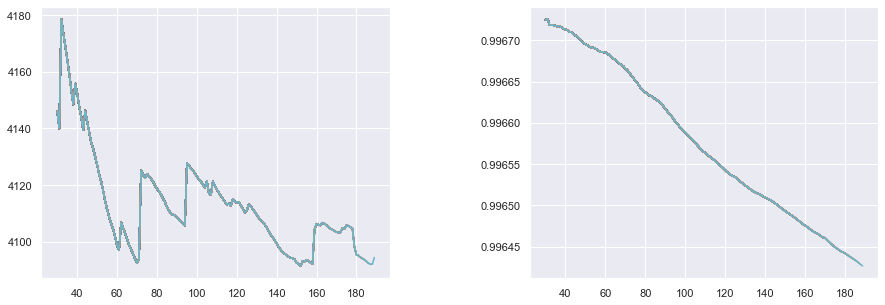

In [73]:
MAE = []  # 找參數，決定使用71個鄰居
R2 = []
ii = []
fig , ax = plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(wspace=0.4)
for i in range(30,190):
    neigh = KNeighborsRegressor(n_neighbors=i+1,weights='distance')
    neigh.fit(train_x, train_y)
    pred_y = neigh.predict(val_x)
    print(f'n = {i+1}')
    print(f'MAE = {mean_absolute_error(val_y, pred_y)}')
    print(f'R^2 = {r2_score(val_y, pred_y)}')
    ii.append(i)
    MAE.append(mean_absolute_error(val_y, pred_y))
    R2.append(r2_score(val_y, pred_y))
    plt.subplot(1,2,1)
    plt.plot(ii,MAE) 
    plt.subplot(1,2,2)
    plt.plot(ii,R2)

warnings.filterwarnings("default")

In [74]:
neigh = KNeighborsRegressor(n_neighbors=71,weights='distance')
neigh.fit(train_x, train_y)
pred1_y = neigh.predict(val_x)

In [75]:
pred1_y = neigh.predict(val_x)

In [76]:
mean_absolute_error(val_y, pred1_y)

4092.4131555028043

In [77]:
r2_score(val_y, pred1_y)

0.9966657695969662

In [78]:
pred2_y = neigh.predict(test_x)

In [79]:
mean_absolute_error(test_y, pred2_y) # 在測試樣本表現良好

4044.3306642869697

In [80]:
r2_score(test_y, pred2_y) # 在測試樣本表現良好

0.9969096938864028

#### 再來測試只用 AMT_CREDIT

In [112]:
x = withGoodsPrice['AMT_CREDIT']
y = withGoodsPrice['AMT_GOODS_PRICE']

In [113]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)  # 共分成3份資料 
val_x, test_x, val_y, test_y = train_test_split(test_x, test_y, test_size=0.5)

In [114]:
print('shape(train_x)=\t\t\t', train_x.shape)
print('shape(train_y)=\t\t\t', train_y.shape)
print('shape(val_x)=\t\t\t', val_x.shape)
print('shape(val_y)=\t\t\t', val_y.shape)
print('shape(test_x)=\t\t\t', test_x.shape)
print('shape(test_y)=\t\t\t', test_y.shape)

shape(train_x)=			 (215054,)
shape(train_y)=			 (215054,)
shape(val_x)=			 (46083,)
shape(val_y)=			 (46083,)
shape(test_x)=			 (46084,)
shape(test_y)=			 (46084,)


x只有一欄，無須正規化

In [115]:
type(train_x)

pandas.core.series.Series

In [116]:
train_x = train_x.values # 將Series轉成array
train_x

array([247500., 284400., 247500., ..., 545040., 112500., 942300.])

In [117]:
train_x = train_x.reshape(-1,1) # 轉形狀，只給KNN一欄x時需要這樣
train_x

array([[247500.],
       [284400.],
       [247500.],
       ...,
       [545040.],
       [112500.],
       [942300.]])

In [119]:
val_x = val_x.values # 跟上面一樣改成array然後轉形狀
val_x = val_x.reshape(-1,1)
val_x

array([[1546020.],
       [1535553.],
       [ 284400.],
       ...,
       [ 701721.],
       [ 900000.],
       [ 808650.]])

In [199]:
import warnings
warnings.filterwarnings("ignore")

n = 21
MAE = 778.7311039891575
R^2 = 0.9991829117834667
n = 22
MAE = 781.459931909229
R^2 = 0.9991848208013674
n = 23
MAE = 779.3440546847208
R^2 = 0.9991879300083206
n = 24
MAE = 777.1263329980028
R^2 = 0.9991901054812303
n = 25
MAE = 774.6442448105729
R^2 = 0.999192626166426
n = 26
MAE = 772.6980231645906
R^2 = 0.9991941154734487
n = 27
MAE = 770.0950064192891
R^2 = 0.9991960990856344
n = 28
MAE = 767.5701149216638
R^2 = 0.9991977404215687
n = 29
MAE = 765.4550621333465
R^2 = 0.9991991421036291
n = 30
MAE = 764.8080863333042
R^2 = 0.9992004731099446
n = 31
MAE = 763.6582818826444
R^2 = 0.9992017851684571
n = 32
MAE = 763.2375154665841
R^2 = 0.9992026624152517
n = 33
MAE = 761.9352789317145
R^2 = 0.9992035701581895
n = 34
MAE = 760.5184673353377
R^2 = 0.9992047434608948
n = 35
MAE = 759.596757294345
R^2 = 0.9992056174363471
n = 36
MAE = 758.8455388740115
R^2 = 0.9992067955299826
n = 37
MAE = 758.7798472591606
R^2 = 0.9992079165477086
n = 38
MAE = 758.2206570387909
R^2 = 0.999208713087

n = 167
MAE = 914.1216483859326
R^2 = 0.9992153797053541
n = 168
MAE = 912.9772667186774
R^2 = 0.999215370851578
n = 169
MAE = 911.9022702293199
R^2 = 0.9992153200626666
n = 170
MAE = 910.8274613325918
R^2 = 0.9992152789148869
n = 171
MAE = 909.7579875125974
R^2 = 0.9992152481250361
n = 172
MAE = 908.690450775098
R^2 = 0.9992152187104758
n = 173
MAE = 916.9459244280733
R^2 = 0.9992151392566984
n = 174
MAE = 915.8195378014781
R^2 = 0.9992151515810698
n = 175
MAE = 914.7045950612429
R^2 = 0.9992151660874041
n = 176
MAE = 913.6051149016938
R^2 = 0.9992151592140197
n = 177
MAE = 912.5165623143247
R^2 = 0.9992151540214946
n = 178
MAE = 911.4318951305052
R^2 = 0.9992151693189525
n = 179
MAE = 910.3585938635642
R^2 = 0.9992151865827675
n = 180
MAE = 909.2892518454578
R^2 = 0.9992151959206329
n = 181
MAE = 926.118339141238
R^2 = 0.9992147128257264
n = 182
MAE = 924.9761549856231
R^2 = 0.9992147240715301
n = 183
MAE = 923.8429648142857
R^2 = 0.9992147583004112
n = 184
MAE = 914.0971089426921
R^

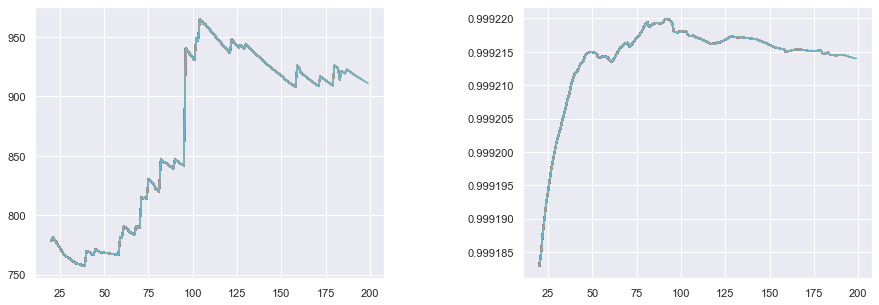

In [200]:
MAE = []  # 找參數，決定使用37個鄰居
R2 = []
ii = []
fig , ax = plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(wspace=0.4)
for i in range(20,200):
    neigh = KNeighborsRegressor(n_neighbors=i+1,weights='distance')
    neigh.fit(train_x, train_y)
    pred_y = neigh.predict(val_x)
    print(f'n = {i+1}')
    print(f'MAE = {mean_absolute_error(val_y, pred_y)}')
    print(f'R^2 = {r2_score(val_y, pred_y)}')
    ii.append(i)
    MAE.append(mean_absolute_error(val_y, pred_y))
    R2.append(r2_score(val_y, pred_y))
    plt.subplot(1,2,1)
    plt.plot(ii,MAE) 
    plt.subplot(1,2,2)
    plt.plot(ii,R2)

warnings.filterwarnings("default")

In [201]:
neigh = KNeighborsRegressor(n_neighbors=37,weights='distance')
neigh.fit(train_x, train_y)
pred1_y = neigh.predict(val_x)

In [202]:
pred1_y = neigh.predict(val_x)

In [203]:
mean_absolute_error(val_y, pred1_y)

758.7798472591606

In [204]:
r2_score(val_y, pred1_y)

0.9992079165477086

In [205]:
test_x = test_x.values # 跟上面一樣改成array然後轉形狀
test_x = test_x.reshape(-1,1)
test_x

array([[1345500.],
       [ 900000.],
       [ 450441.],
       ...,
       [ 392427.],
       [ 314100.],
       [  71955.]])

In [206]:
pred2_y = neigh.predict(test_x)

In [207]:
mean_absolute_error(test_y, pred2_y) # 在測試樣本表現良好，只用AMT_CREDIT比加入AMT_GOODS_PRICE好

707.322385958071

In [208]:
r2_score(test_y, pred2_y) # 在測試樣本表現良好

0.9991997675197822

### 以KNN填補AMT_GOODS_PRICE的空值 (只用AMT_CREDIT預測)

In [44]:
highCorCol.isna().sum()

AMT_ANNUITY          0
AMT_GOODS_PRICE    278
AMT_CREDIT           0
dtype: int64

In [45]:
highCorCol.head()

,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_CREDIT
0,24700.5,351000.0,406597.5
1,35698.5,1129500.0,1293502.5
2,6750.0,135000.0,135000.0
3,29686.5,297000.0,312682.5
4,21865.5,513000.0,513000.0


In [46]:
highCorCol = highCorCol.drop('AMT_ANNUITY',axis=1) # 只用AMT_CREDIT預測
highCorCol.head()

,AMT_GOODS_PRICE,AMT_CREDIT
0,351000.0,406597.5
1,1129500.0,1293502.5
2,135000.0,135000.0
3,297000.0,312682.5
4,513000.0,513000.0


In [47]:
imputer = KNNImputer(n_neighbors=37, weights="distance")

In [48]:
highCorColImputed = imputer.fit_transform(highCorCol)

In [49]:
highCorColImputed = pd.DataFrame(highCorColImputed)

In [50]:
highCorColImputed.isna().sum()

0    0
1    0
dtype: int64

In [51]:
temp = pd.DataFrame.copy(highCorCol,True) # 要用pandas.DataFrame.copy，之後更動temp才不會更動到原表
temp['0']=highCorColImputed[0]
temp['1']=highCorColImputed[1]

In [52]:
temp

,AMT_GOODS_PRICE,AMT_CREDIT,0,1
0,351000.0,406597.5,351000.0,406597.5
1,1129500.0,1293502.5,1129500.0,1293502.5
2,135000.0,135000.0,135000.0,135000.0
3,297000.0,312682.5,297000.0,312682.5
4,513000.0,513000.0,513000.0,513000.0
...,...,...,...,...
307506,225000.0,254700.0,225000.0,254700.0
307507,225000.0,269550.0,225000.0,269550.0
307508,585000.0,677664.0,585000.0,677664.0
307509,319500.0,370107.0,319500.0,370107.0


In [53]:
assert (temp['AMT_CREDIT']-temp['1'] == 0).sum() == 307511 # 確認補值的表正確

In [54]:
train['AMT_GOODS_PRICE'] = highCorColImputed[0]

In [55]:
train[['AMT_GOODS_PRICE','AMT_CREDIT','AMT_ANNUITY']].isna().sum()

AMT_GOODS_PRICE    0
AMT_CREDIT         0
AMT_ANNUITY        0
dtype: int64

In [71]:
train2['AMT_GOODS_PRICE_FLAG'] = train2['AMT_GOODS_PRICE'].isna().replace(True,1)
train['AMT_GOODS_PRICE_FLAG'] = train2['AMT_GOODS_PRICE_FLAG']
train['AMT_GOODS_PRICE_FLAG'].sum()

278.0

補好這三個了 'AMT_GOODS_PRICE','AMT_CREDIT','AMT_ANNUITY'

### 補其他類別型欄位的空值

In [56]:
train[data_object_na].isna().sum()

NAME_TYPE_SUITE          1292
OCCUPATION_TYPE         96391
FONDKAPREMONT_MODE     210295
HOUSETYPE_MODE         154297
WALLSMATERIAL_MODE     156341
EMERGENCYSTATE_MODE    145755
dtype: int64

In [57]:
for column in data_object_na:
    print(f'{column}:\n{train[column].unique()}')

NAME_TYPE_SUITE:
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
OCCUPATION_TYPE:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
FONDKAPREMONT_MODE:
['reg oper account' nan 'org spec account' 'reg oper spec account'
 'not specified']
HOUSETYPE_MODE:
['block of flats' nan 'terraced house' 'specific housing']
WALLSMATERIAL_MODE:
['Stone, brick' 'Block' nan 'Panel' 'Mixed' 'Wooden' 'Others' 'Monolithic']
EMERGENCYSTATE_MODE:
['No' nan 'Yes']


In [58]:
for column in data_object_na:
    train[f'{column}_FLAG'] = train[column].isna().replace(True,1)
    train[column] = train[column].replace(np.nan,'NA')
    assert train[train[column]=='NA'].shape[0] == train[f'{column}_FLAG'].sum() # 檢查NA數與FLAG數一樣
train[data_object_na].isna().sum() # 補好了

NAME_TYPE_SUITE        0
OCCUPATION_TYPE        0
FONDKAPREMONT_MODE     0
HOUSETYPE_MODE         0
WALLSMATERIAL_MODE     0
EMERGENCYSTATE_MODE    0
dtype: int64

In [59]:
for column in data_object_na: # 確認填補後的unique值
    print(f'{column}:\n{train[column].unique()}')
    print(f'NA:\t{train[column].value_counts()["NA"]}')

NAME_TYPE_SUITE:
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'NA'
 'Other_B' 'Group of people']
NA:	1292
OCCUPATION_TYPE:
['Laborers' 'Core staff' 'Accountants' 'Managers' 'NA' 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
NA:	96391
FONDKAPREMONT_MODE:
['reg oper account' 'NA' 'org spec account' 'reg oper spec account'
 'not specified']
NA:	210295
HOUSETYPE_MODE:
['block of flats' 'NA' 'terraced house' 'specific housing']
NA:	154297
WALLSMATERIAL_MODE:
['Stone, brick' 'Block' 'NA' 'Panel' 'Mixed' 'Wooden' 'Others'
 'Monolithic']
NA:	156341
EMERGENCYSTATE_MODE:
['No' 'NA' 'Yes']
NA:	145755


### 補float類型欄位的空值

In [61]:
data_float_na

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPART

In [62]:
data_float_na = data_float_na.drop(['AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS']) # drop掉這三欄，另外處理
data_float_na

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_

In [63]:
train[data_float_na].isna().sum()

OWN_CAR_AGE                     202929
EXT_SOURCE_1                    173378
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG                   154828
FLOORSMAX_AVG                   153020
FLOORSMIN_AVG                   208642
LANDAREA_AVG                    182590
LIVINGAPARTMENTS_AVG            210199
LIVINGAREA_AVG                  154350
NONLIVINGAPARTMENTS_AVG         213514
NONLIVINGAREA_AVG               169682
APARTMENTS_MODE                 156061
BASEMENTAREA_MODE               179943
YEARS_BEGINEXPLUATATION_MODE    150007
YEARS_BUILD_MODE                204488
COMMONAREA_MODE                 214865
ELEVATORS_MODE                  163891
ENTRANCES_MODE                  154828
FLOORSMAX_MODE           

In [64]:
train['CNT_FAM_MEMBERS'].mode()

0    2.0
dtype: float64

In [178]:
#train['CNT_FAM_MEMBERS']=train2['CNT_FAM_MEMBERS'] # 做錯時復原用

In [193]:
#train[data_float_na]=train2[data_float_na] # 做錯時復原用

In [65]:
train['CNT_FAM_MEMBERS'] = train['CNT_FAM_MEMBERS'].fillna(value=2) # value不能填入train['CNT_FAM_MEMBERS'].mode()
train['CNT_FAM_MEMBERS'].isna().sum() # CNT_FAM_MEMBERS缺值填入眾數

0

In [66]:
for column in data_float_na: # 填補完成
    train[f'{column}_FLAG'] = train[column].isna().replace(True,1)
    train[column] = train[column].fillna(value=0)
#     assert train[train[column]==0].shape[0] == train[f'{column}_FLAG'].sum() # NA數與FLAG數不一定一樣，所以不能這樣檢查，原值也有0
train[data_float_na].isna().sum()

OWN_CAR_AGE                     0
EXT_SOURCE_1                    0
EXT_SOURCE_2                    0
EXT_SOURCE_3                    0
APARTMENTS_AVG                  0
BASEMENTAREA_AVG                0
YEARS_BEGINEXPLUATATION_AVG     0
YEARS_BUILD_AVG                 0
COMMONAREA_AVG                  0
ELEVATORS_AVG                   0
ENTRANCES_AVG                   0
FLOORSMAX_AVG                   0
FLOORSMIN_AVG                   0
LANDAREA_AVG                    0
LIVINGAPARTMENTS_AVG            0
LIVINGAREA_AVG                  0
NONLIVINGAPARTMENTS_AVG         0
NONLIVINGAREA_AVG               0
APARTMENTS_MODE                 0
BASEMENTAREA_MODE               0
YEARS_BEGINEXPLUATATION_MODE    0
YEARS_BUILD_MODE                0
COMMONAREA_MODE                 0
ELEVATORS_MODE                  0
ENTRANCES_MODE                  0
FLOORSMAX_MODE                  0
FLOORSMIN_MODE                  0
LANDAREA_MODE                   0
LIVINGAPARTMENTS_MODE           0
LIVINGAREA_MOD

In [67]:
pd.set_option('display.max_columns',None) # 最右側新增一堆FLAG欄位，標註是否為NA
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_FLAG,OCCUPATION_TYPE_FLAG,FONDKAPREMONT_MODE_FLAG,HOUSETYPE_MODE_FLAG,WALLSMATERIAL_MODE_FLAG,EMERGENCYSTATE_MODE_FLAG,OWN_CAR_AGE_FLAG,EXT_SOURCE_1_FLAG,EXT_SOURCE_2_FLAG,EXT_SOURCE_3_FLAG,APARTMENTS_AVG_FLAG,BASEMENTAREA_AVG_FLAG,YEARS_BEGINEXPLUATATION_AVG_FLAG,YEARS_BUILD_AVG_FLAG,COMMONAREA_AVG_FLAG,ELEVATORS_AVG_FLAG,ENTRANCES_AVG_FLAG,FLOORSMAX_AVG_FLAG,FLOORSMIN_AVG_FLAG,LANDAREA_AVG_FLAG,LIVINGAPARTMENTS_AVG_FLAG,LIVINGAREA_AVG_FLAG,NONLIVINGAPARTMENTS_AVG_FLAG,NONLIVINGAREA_AVG_FLAG,APARTMENTS_MODE_FLAG,BASEMENTAREA_MODE_FLAG,YEARS_BEGINEXPLUATATION_MODE_FLAG,YEARS_BUILD_MODE_FLAG,COMMONAREA_MODE_FLAG,ELEVATORS_MODE_FLAG,ENTRANCES_MODE_FLAG,FLOORSMAX_MODE_FLAG,FLOORSMIN_MODE_FLAG,LANDAREA_MODE_FLAG,LIVINGAPARTMENTS_MODE_FLAG,LIVINGAREA_MODE_FLAG,NONLIVINGAPARTMENTS_MODE_FLAG,NONLIVINGAREA_MODE_FLAG,APARTMENTS_MEDI_FLAG,BASEMENTAREA_MEDI_FLAG,YEARS_BEGINEXPLUATATION_MEDI_FLAG,YEARS_BUILD_MEDI_FLAG,COMMONAREA_MEDI_FLAG,ELEVATORS_MEDI_FLAG,ENTRANCES_MEDI_FLAG,FLOORSMAX_MEDI_FLAG,FLOORSMIN_MEDI_FLAG,LANDAREA_MEDI_FLAG,LIVINGAPARTMENTS_MEDI_FLAG,LIVINGAREA_MEDI_FLAG,NONLIVINGAPARTMENTS_MEDI_FLAG,NONLIVINGAREA_MEDI_FLAG,TOTALAREA_MODE_FLAG,OBS_30_CNT_SOCIAL_CIRCLE_FLAG,DEF_30_CNT_SOCIAL_CIRCLE_FLAG,OBS_60_CNT_SOCIAL_CIRCLE_FLAG,DEF_60_CNT_SOCIAL_CIRCLE_FLAG,DAYS_LAST_PHONE_CHANGE_FLAG,AMT_REQ_CREDIT_BUREAU_HOUR_FLAG,AMT_REQ_CREDIT_BUREAU_DAY_FLAG,AMT_REQ_CREDIT_BUREAU_WEEK_FLAG,AMT_REQ_CREDIT_BUREAU_MON_FLAG,AMT_REQ_CREDIT_BUREAU_QRT_FLAG,AMT_REQ_CREDIT_BUREAU_YEAR_FLAG
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.2

In [73]:
train2 = pd.read_csv("C:\\final\\home-credit-default-risk\\application_train.csv") # 備用復原

In [74]:
train.shape[1] - train2.shape[1] # 共新增66欄標註是否為空值

66

## 處理異常資料

In [97]:
train['DAYS_EMPLOYED'] = train2['DAYS_EMPLOYED']

In [98]:
train['DAYS_EMPLOYED'].describe() # 將DAYS_EMPLOYED的異常值表註並改成0

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [99]:
# train['DAYS_EMPLOYED_FLAG'] = train['DAYS_EMPLOYED']
train['DAYS_EMPLOYED_FLAG'] = (train['DAYS_EMPLOYED'] == 365243).replace(True,1) # 標註異常欄位
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace(365243,0) # 異常值改為0

In [100]:
assert train['DAYS_EMPLOYED_FLAG'].sum() == (train2['DAYS_EMPLOYED'] == 365243).sum()

In [101]:
train.shape[1] - train2.shape[1] # 共新增66欄標註是否為空值

67

In [102]:
train.to_csv('C:\\final\\arranged\\application_train_cleaning_v1.csv',index = False)

In [103]:
checkNewTable = pd.read_csv("C:\\final\\arranged\\application_train_cleaning_v1.csv")

In [104]:
pd.set_option('display.max_rows',None)
checkNewTable.head(15)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_FLAG,OCCUPATION_TYPE_FLAG,FONDKAPREMONT_MODE_FLAG,HOUSETYPE_MODE_FLAG,WALLSMATERIAL_MODE_FLAG,EMERGENCYSTATE_MODE_FLAG,OWN_CAR_AGE_FLAG,EXT_SOURCE_1_FLAG,EXT_SOURCE_2_FLAG,EXT_SOURCE_3_FLAG,APARTMENTS_AVG_FLAG,BASEMENTAREA_AVG_FLAG,YEARS_BEGINEXPLUATATION_AVG_FLAG,YEARS_BUILD_AVG_FLAG,COMMONAREA_AVG_FLAG,ELEVATORS_AVG_FLAG,ENTRANCES_AVG_FLAG,FLOORSMAX_AVG_FLAG,FLOORSMIN_AVG_FLAG,LANDAREA_AVG_FLAG,LIVINGAPARTMENTS_AVG_FLAG,LIVINGAREA_AVG_FLAG,NONLIVINGAPARTMENTS_AVG_FLAG,NONLIVINGAREA_AVG_FLAG,APARTMENTS_MODE_FLAG,BASEMENTAREA_MODE_FLAG,YEARS_BEGINEXPLUATATION_MODE_FLAG,YEARS_BUILD_MODE_FLAG,COMMONAREA_MODE_FLAG,ELEVATORS_MODE_FLAG,ENTRANCES_MODE_FLAG,FLOORSMAX_MODE_FLAG,FLOORSMIN_MODE_FLAG,LANDAREA_MODE_FLAG,LIVINGAPARTMENTS_MODE_FLAG,LIVINGAREA_MODE_FLAG,NONLIVINGAPARTMENTS_MODE_FLAG,NONLIVINGAREA_MODE_FLAG,APARTMENTS_MEDI_FLAG,BASEMENTAREA_MEDI_FLAG,YEARS_BEGINEXPLUATATION_MEDI_FLAG,YEARS_BUILD_MEDI_FLAG,COMMONAREA_MEDI_FLAG,ELEVATORS_MEDI_FLAG,ENTRANCES_MEDI_FLAG,FLOORSMAX_MEDI_FLAG,FLOORSMIN_MEDI_FLAG,LANDAREA_MEDI_FLAG,LIVINGAPARTMENTS_MEDI_FLAG,LIVINGAREA_MEDI_FLAG,NONLIVINGAPARTMENTS_MEDI_FLAG,NONLIVINGAREA_MEDI_FLAG,TOTALAREA_MODE_FLAG,OBS_30_CNT_SOCIAL_CIRCLE_FLAG,DEF_30_CNT_SOCIAL_CIRCLE_FLAG,OBS_60_CNT_SOCIAL_CIRCLE_FLAG,DEF_60_CNT_SOCIAL_CIRCLE_FLAG,DAYS_LAST_PHONE_CHANGE_FLAG,AMT_REQ_CREDIT_BUREAU_HOUR_FLAG,AMT_REQ_CREDIT_BUREAU_DAY_FLAG,AMT_REQ_CREDIT_BUREAU_WEEK_FLAG,AMT_REQ_CREDIT_BUREAU_MON_FLAG,AMT_REQ_CREDIT_BUREAU_QRT_FLAG,AMT_REQ_CREDIT_BUREAU_YEAR_FLAG,AMT_ANNUITY_FLAG,AMT_GOODS_PRICE_FLAG,DAYS_EMPLOYED_FLAG
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,W

## 處理離群值 (暫不處理)

In [38]:
a = np.array([1,2,3,4,5])
a

array([1, 2, 3, 4, 5])

In [45]:
np.quantile(a,q=0.25)

2.0

In [49]:
(train['AMT_CREDIT'].quantile(q=0.75)-train['AMT_CREDIT'].quantile(q=0.25))*1.5+train['AMT_CREDIT'].quantile(q=0.75)
# Q3+1.5*IQR

1616625.0

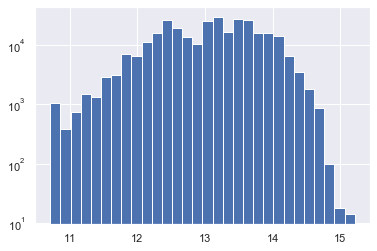

In [58]:
import math
train['AMT_CREDIT'].apply(lambda x: math.log(x)).hist(bins=30,log=True) # 

AMT_CREDIT雖然以四分位數法看會有離群值，但取log後就沒有

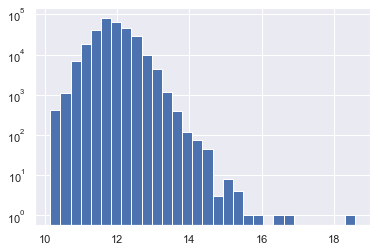

In [60]:
import math
train['AMT_INCOME_TOTAL'].apply(lambda x: math.log(x)).hist(bins=30,log=True)

AMT_INCOME_TOTAL取log後還是有離群值